In [1]:
import time
import numpy as np
import pandas as pd
import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from models import ParticleNet
import torch
import torch.nn as nn
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

## TEST TRAINING

In [2]:
! ls ./

ParticleNet_1     Roc_curve.pdf     particlenet.ipynb
ParticleNet_6     fastjet.ipynb     results.pdf
ParticleNet_model paper             xai_plots


In [4]:
# load the trained model
device = 'cpu'
PATH = "ParticleNet_6"
PATH = "ParticleNet_1"

with open(f"{PATH}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

state_dict = torch.load(f"{PATH}/best_epoch_weights.pth", map_location=device)

model = ParticleNet(**model_kwargs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
test_data = torch.load("../data/toptagging/test/processed/data_0.pt")
loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [6]:
sig = nn.Sigmoid()

y_score = None
y_test = None
for i, batch in enumerate(loader):
    preds, _, _, _ = model(batch)
    preds = sig(preds).detach()
    
    if y_score == None:
        y_score = preds[:].reshape(-1)
        y_test = batch.y
    else:
        y_score = torch.cat([y_score, preds[:].reshape(-1)])
        y_test = torch.cat([y_test, batch.y]) 
        
    if i==10000:
        break

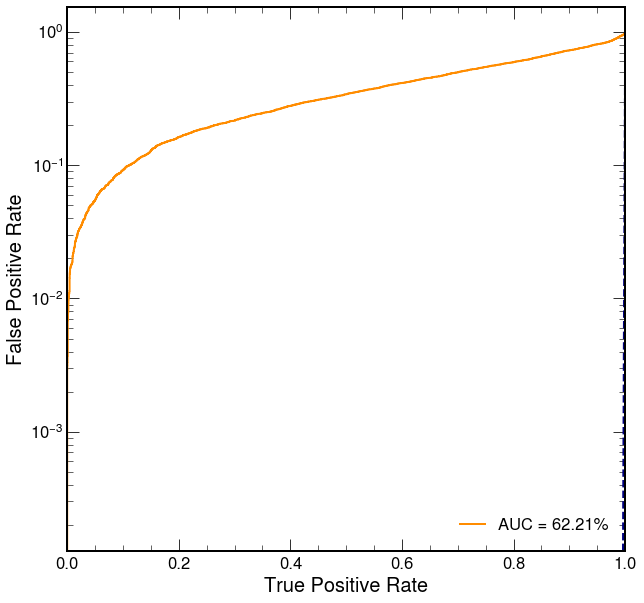

<Figure size 720x720 with 0 Axes>

In [7]:
# Compute ROC curve and ROC area for each class    
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale('log')
# plt.title("")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');

## TEST LRP

In [53]:
import pandas as pd
import numpy as np

df = pd.read_hdf("../data/toptagging/test/raw/test.h5", key="table", start=1000, stop=1002)
print(f"{df['is_signal_new'].values=}")

df['is_signal_new'].values=array([1, 1])


In [5]:
# load the trained model
device = 'cpu'
PATH = "ParticleNet_6"
# PATH = "ParticleNet_drop"

with open(f"{PATH}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

# state_dict = torch.load(f"{PATH}/best_epoch_weights.pth", map_location=device)
state_dict = torch.load(f"{PATH}/epoch_0_weights.pth", map_location=device)

model = ParticleNet(**model_kwargs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [42]:
def get_dr_Mij(trained=True):
    dr_top = []
    dr_qcd = []
    Mij_top = []
    Mij_qcd= []
        
    if trained:
        loops = 1    
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):
        if loops!=1:
            PATH = f"ParticleNet_6/Rscores_{loop}"
        else:
            PATH = "ParticleNet_6/Rscores_best"

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)

        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)     

        for i in range(len(batch_y_list)):

            jet_label = batch_y_list[i]
            jet_input = batch_x_list[i]

            R_edges = R_edges_list[i]
            edge_index = edge_index_list[i]

            if trained:        
                R_edges = R_edges['edge_conv_2']
                edge_index = edge_index['edge_conv_2']

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            p = torch.sqrt(torch.square(px) + torch.square(py) + torch.square(pz))

            # recall: Features, in order: [eta, phi, pt, mask].
            eta = jet_input[:, 0]
            phi = jet_input[:, 1]
            pt = np.abs(jet_input[:, 2])

            eta_phi = jet_input[:, :2]

            # build graph
            edge_index, edge_weight = edge_index, torch.abs(R_edges).sum(axis=1)
            edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

            def deltaR(eta1, eta2, phi1, phi2):
                return torch.sqrt(torch.square(eta2-eta1) + torch.square(phi2-phi1))

            top_5_edges = torch.topk(edge_Rscores, 5).indices   # pick top 5 edge Rscores, get the indices

            for edge in top_5_edges:
                particle_1 = edge_index[0][edge]
                particle_2 = edge_index[1][edge]

                px1 = px[particle_1]
                py1 = py[particle_1]
                pz1 = pz[particle_1]

                px2 = px[particle_2]
                py2 = py[particle_2]
                pz2 = pz[particle_2]

                eta1 = eta[particle_1]
                eta2 = eta[particle_2]

                phi1 = phi[particle_1]
                phi2 = phi[particle_2]

                e1 = e[particle_1]
                e2 = e[particle_2]

                M12 = torch.sqrt(torch.square(e1+e2) - torch.square(px1+ px2) - torch.square(py1+py2) - torch.square(pz1+pz2))

                if jet_label==1:
                    dr_top.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_top.append(M12)
                else:
                    dr_qcd.append(deltaR(eta1, eta2, phi1, phi2).item())
                    Mij_qcd.append(M12) 

    return dr_top, dr_qcd, Mij_top, Mij_qcd

In [43]:
dr_top_trained, dr_qcd_trained, Mij_top_trained, Mij_qcd_trained = get_dr_Mij(trained=True)
dr_top_untrained, dr_qcd_untrained, Mij_top_untrained, Mij_qcd_untrained = get_dr_Mij(trained=False)

No handles with labels found to put in legend.
<ipython-input-186-f49553a25858>:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
No handles with labels found to put in legend.
<ipython-input-186-f49553a25858>:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


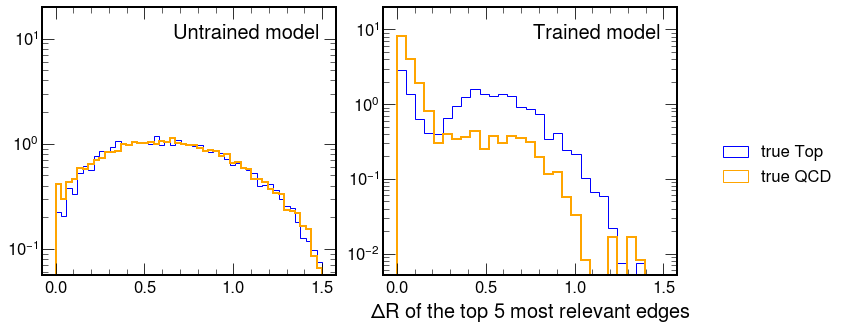

In [186]:
# get legend
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(dr_top_untrained, color="Blue", label='true Top', histtype='step')
ax.hist(dr_qcd_untrained, color="Orange", label='true QCD', histtype='step')
legend_stuff = ax.get_legend_handles_labels()
plt.close()

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(dr_top_untrained, bins=np.linspace(0, 1.5, 50), color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(dr_qcd_untrained, bins=np.linspace(0, 1.5, 50), color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)

axes[1].hist(dr_top_trained, bins=np.linspace(0, 1.5, 30), color="Blue",histtype='step', linewidth=1, density=True)
axes[1].hist(dr_qcd_trained, bins=np.linspace(0, 1.5, 30), color="Orange",   histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)

axes[1].set_xlabel('$\Delta$R of the top 5 most relevant edges')
fig.legend(legend_stuff[0], legend_stuff[1], loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.80)

plt.savefig('paper/deltaR.pdf')
plt.show()

No handles with labels found to put in legend.
<ipython-input-185-cdf5c13b1094>:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[0].set_ylim(0,20)
No handles with labels found to put in legend.
<ipython-input-185-cdf5c13b1094>:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim(0,20)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


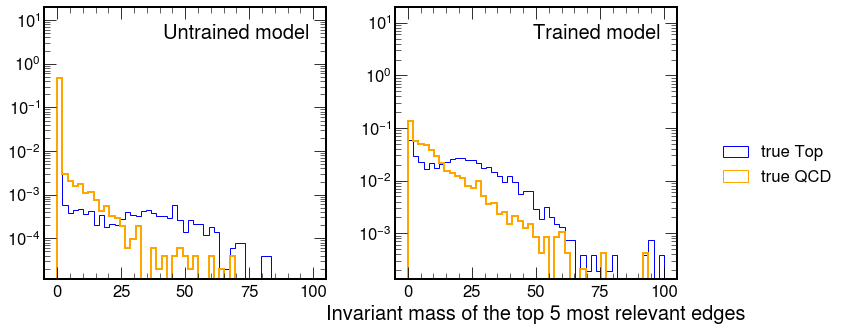

In [185]:
# get legend
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(Mij_top_untrained, color="Blue", label='true Top', histtype='step')
ax.hist(Mij_qcd_untrained, color="Orange", label='true QCD', histtype='step')
legend_stuff = ax.get_legend_handles_labels()
plt.close()

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].hist(Mij_top_untrained, bins=np.linspace(0,100), color="Blue", histtype='step', linewidth=1, density=True)
axes[0].hist(Mij_qcd_untrained, bins=np.linspace(0,100), color="Orange", histtype='step', linewidth=2, density=True)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)

axes[1].hist(Mij_top_trained, bins=np.linspace(0,100), color="Blue", histtype='step', linewidth=1, density=True)
axes[1].hist(Mij_qcd_trained, bins=np.linspace(0,100), color="Orange", histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)

axes[1].set_xlabel('Invariant mass of the top 5 most relevant edges')
fig.legend(legend_stuff[0], legend_stuff[1], loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.80)

plt.savefig('paper/Mij.pdf')
plt.show()

In [107]:
PATH = "ParticleNet_6/before_training"

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)     

In [42]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

sig = nn.Sigmoid()

### Edge features Rscores
score = 0 # qcd
# score = 1 # top

c = 0

length_top = []
length_qcd = []

for i in range(len(batch_y_list)):
        
    batch_y = batch_y_list[i]
#     if batch_y==score:

#         if c==1:
#             break    
#         c +=1            
    batch_x = batch_x_list[i]
    R_edges = R_edges_list[i]
    edge_index = edge_index_list[i]

    if batch_y==1:
        sample = 'top'
    else:
        sample = 'qcd'

#     model_score = round(sig(model(Batch(x=batch_x, y=batch_y, batch=torch.zeros(len(batch_x), dtype=int)))[0]).item(),3)            

    num_nodes = len(batch_x)

    # Get positions of nodes in the graph
    # recall: Features, in order: [eta, phi, pt, mask].
    eta = batch_x[:, 0]
    phi = batch_x[:, 1]
    pt = np.abs(batch_x[:, 2])

    eta_phi = batch_x[:, :2]

#     pos = {}
#     for node_i in range(num_nodes):
#         pos[node_i] = eta_phi.numpy()[node_i]

    # build graph
    edge_index, edge_weight = edge_index, torch.abs(R_edges).sum(axis=1)
    edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1


    def deltaR(eta1, eta2, phi1, phi2):
        return torch.sqrt(torch.square(eta2-eta1) + torch.square(phi2-phi1))

    top_5_edges = torch.topk(edge_Rscores, 20).indices   # pick top 5 edge Rscores, get the indices

    for edge in top_5_edges:
        eta1 = eta[edge_index[0][edge]]
        eta2 = eta[edge_index[1][edge]]

        phi1 = phi[edge_index[0][edge]]
        phi2 = phi[edge_index[1][edge]]

        if sample=='top':
            length_top.append(deltaR(eta1, eta2, phi1, phi2).item())
        else:
            length_qcd.append(deltaR(eta1, eta2, phi1, phi2).item())
            

#             data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
#             G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

#             fig, ax = plt.subplots(figsize=(10, 8))
#             nx.draw_networkx(G, pos, node_size=10*pt, with_labels=False, width=40*(edge_Rscores), ax=ax, label=f"{edgeconv}")   

#             ax.set_xlabel(r"$\eta$", fontsize=20)
#             ax.set_ylabel(r"$\phi$", fontsize=20);
#             ax.set_title(f'Sample {sample} jet {i} with score {model_score}: after {edgeconv}', fontsize=20);
#             ax.legend()
#             plt.show();
#             plt.savefig(f'xai_plots/{edgeconv}.pdf');

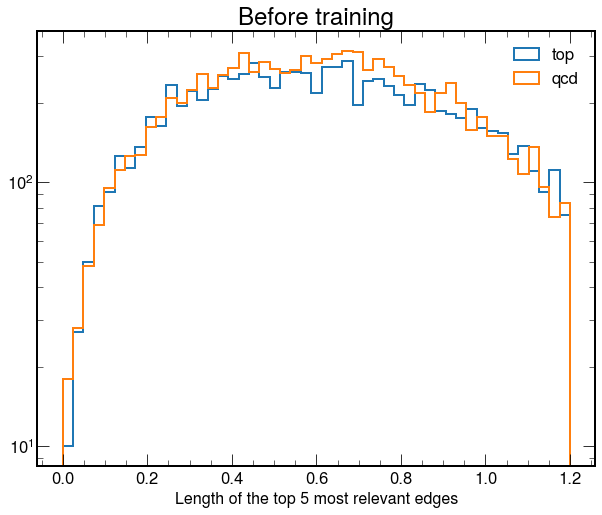

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(length_top, bins=np.linspace(0,1.2), label='top', histtype='step', linewidth=2)
ax.hist(length_qcd, bins=np.linspace(0,1.2), label='qcd', histtype='step', linewidth=2)
ax.set_xlabel(r"Length of the top 5 most relevant edges", fontsize=16)
ax.legend()
ax.set_title('Before training')
ax.set_yscale('log')
# plt.savefig(f"{PATH}/top_3.pdf")
plt.show()

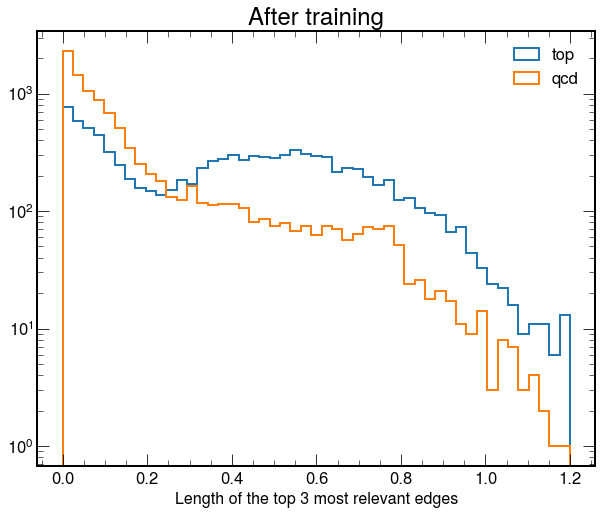

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(length_top_best_epoch, bins=np.linspace(0,1.2), label='top', histtype='step', linewidth=2)
ax.hist(length_qcd_best_epoch, bins=np.linspace(0,1.2), label='qcd', histtype='step', linewidth=2)
ax.set_xlabel(r"Length of the top 5 most relevant edges", fontsize=16)
ax.legend()
ax.set_title('After training')
ax.set_yscale('log')
# plt.savefig(f"{PATH}/top_3.pdf")
plt.show()

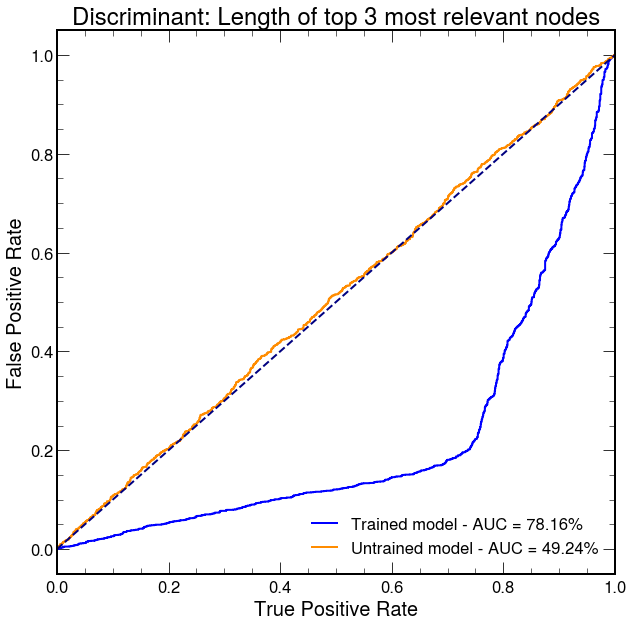

<Figure size 720x720 with 0 Axes>

In [151]:
# Compute ROC curve and ROC area for each class    

score = length_top_best_epoch + length_qcd_best_epoch
label = [1] * len(length_top_best_epoch) + [0] * len(length_qcd_best_epoch)
fpr_trained, tpr_trained, _ = roc_curve(label, score)
roc_auc = auc(fpr_trained, tpr_trained)

score = length_top + length_qcd
label = [1] * len(length_top) + [0] * len(length_qcd)
fpr_untrained, tpr_untrained, _ = roc_curve(label, score)
roc_auc_untrained = auc(fpr_untrained, tpr_untrained)

fig, ax = plt.subplots()
ax.plot(
    tpr_trained,
    fpr_trained,
    color="blue",
    lw=2,
    label=f"Trained model - AUC = {round(auc(fpr_trained, tpr_trained)*100,2)}%",
)
ax.plot(
    tpr_untrained,
    fpr_untrained,
    color="darkorange",
    lw=2,
    label=f"Untrained model - AUC = {round(auc(fpr_untrained, tpr_untrained)*100,2)}%",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
# plt.yscale('log')
plt.title("Discriminant: Length of top 3 most relevant nodes")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


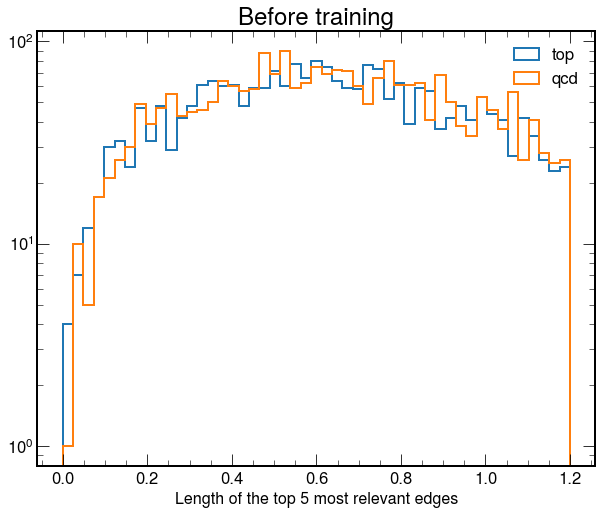

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(length_top, bins=np.linspace(0,1.2), label='top', histtype='step', linewidth=2)
ax.hist(length_qcd, bins=np.linspace(0,1.2), label='qcd', histtype='step', linewidth=2)
ax.set_xlabel(r"Length of the top 5 most relevant edges", fontsize=16)
ax.legend()
ax.set_title('Before training')
ax.set_yscale('log')
plt.savefig(f"{PATH}/top_3.pdf")
plt.show()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


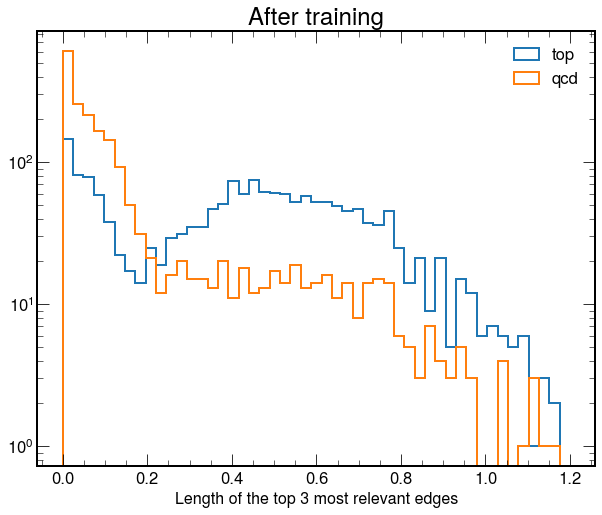

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(length_top_best_epoch, bins=np.linspace(0,1.2), label='top', histtype='step', linewidth=2)
ax.hist(length_qcd_best_epoch, bins=np.linspace(0,1.2), label='qcd', histtype='step', linewidth=2)
ax.set_xlabel(r"Length of the top 3 most relevant edges", fontsize=16)
ax.legend()
ax.set_title('After training')
ax.set_yscale('log')
plt.savefig(f"{PATH}/top_3.pdf")
plt.show()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


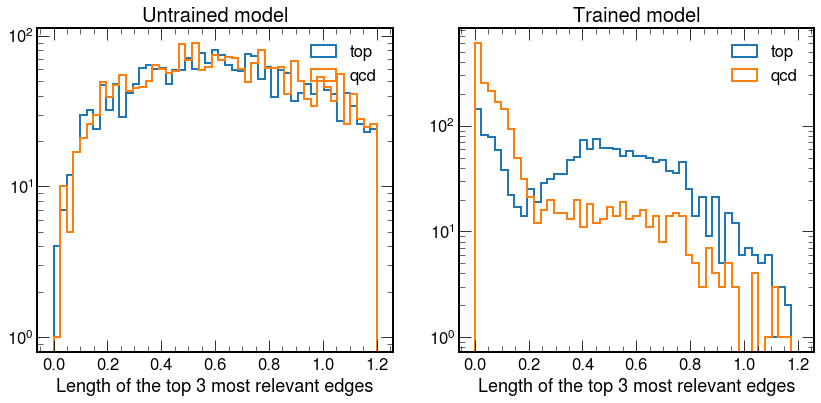

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(length_top, bins=np.linspace(0,1.2), label='top', histtype='step', linewidth=2)
ax1.hist(length_qcd, bins=np.linspace(0,1.2), label='qcd', histtype='step', linewidth=2)
ax1.set_xlabel("Length of the top 3 most relevant edges", fontsize=18)
ax1.set_title('Untrained model', fontsize=20)
ax1.legend()
ax1.set_yscale('log')

ax2.hist(length_top_best_epoch, bins=np.linspace(0,1.2), label='top', histtype='step', linewidth=2)
ax2.hist(length_qcd_best_epoch, bins=np.linspace(0,1.2), label='qcd', histtype='step', linewidth=2)
ax2.set_xlabel("Length of the top 3 most relevant edges", fontsize=18)
ax2.set_title('Trained model', fontsize=20)
ax2.legend()
ax2.set_yscale('log')

fig.tight_layout()
plt.savefig(f"{PATH}/trained_vs_untrained.pdf")

In [99]:

for i in range(len(edge_index[0])):
    if edge_index[1][i]==1 and edge_index[0][i]==0:
        print(i)

13


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


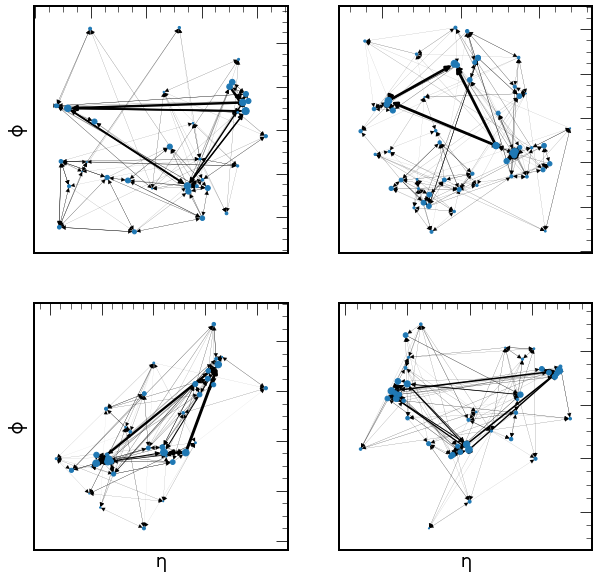

In [145]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

sig = nn.Sigmoid()

### Edge features Rscores
score = 0 # qcd
score = 1 # top


fig, axs = plt.subplots(2, 2)
axss = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
d = 0
for i in range(1000):
    if i not in [785, 270, 155, 168]:
        continue        

    batch_y = batch_y_list[i]
    if batch_y==score:
        batch_x = batch_x_list[i]
        Rscores = Rscores_list[i]
        R_edges = R_edges_list[i]
        edge_index_dic = edge_index_list[i]

        if batch_y==1:
            sample = 'top'
        else:
            sample = 'qcd'

        model_score = round(sig(model(Batch(x=batch_x, y=batch_y, batch=torch.zeros(len(batch_x), dtype=int)))[0]).item(),3)            
        if model_score>0.8:

            num_nodes = len(Rscores)

            node_Rscores = torch.abs(Rscores).sum(axis=1)   # sum features Rscores per node
            input_Rscores = node_Rscores/sum(node_Rscores)  # normalize sum of Rscores of all nodes to be 1  

            # Get positions of nodes in the graph
            # recall: Features, in order: [eta, phi, pt, mask].
            eta = batch_x[:, 0]
            phi = batch_x[:, 1]
            pt = np.abs(batch_x[:, 2])

            eta_phi = batch_x[:, :2]

            pos = {}
            for node_i in range(num_nodes):
                pos[node_i] = eta_phi.numpy()[node_i]

            # build graph
            to_undirected = False

#             for edgeconv in ['edge_conv_0', 'edge_conv_1', 'edge_conv_2']:
            for edgeconv in ['edge_conv_2']:    

                if to_undirected == False:  # if directed
                    edge_index, edge_weight = edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1)
                else: # if undirected
                    edge_index, edge_weight = torch_geometric.utils.to_undirected(edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1))

                edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1


    #             pairs = []
    #             for i in range(3):
    #                 ind = np.argsort(edge_Rscores.numpy())[i]
    #                 pairs.append((edge_index[0][ind],edge_index[1][ind]))
    #             print(pairs)
    #             print(np.argsort(input_Rscores.numpy())[:3])

    #             print('----------------')

                data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
                G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

#                 fig, ax = plt.subplots(figsize=(10, 8))
                nx.draw_networkx(G, pos, node_size=10*pt, with_labels=False, width=40*(edge_Rscores), ax=axss[d], label=f"{edgeconv}")   
                d = d+1
    #             nx.draw_networkx(G, pos, node_size=500*input_Rscores, with_labels=False, width=20*(edge_Rscores), ax=ax, label=f"{edgeconv}")   

for ax in axs.flat:
    ax.set(xlabel=r"$\eta$", ylabel=r"$\phi$")
    
for ax in fig.get_axes():
    ax.label_outer()    
# axs.set_xlabel(r"$\eta$", fontsize=20)
# axs.set_ylabel(r"$\phi$", fontsize=20);
# ax.set_title(f'Sample {sample} jet {i} with score {model_score}: after {edgeconv}', fontsize=20);
# ax.legend()
# plt.show();
plt.savefig(f'lol.pdf');

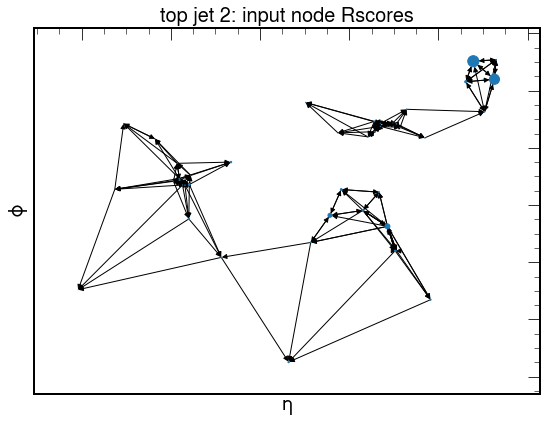

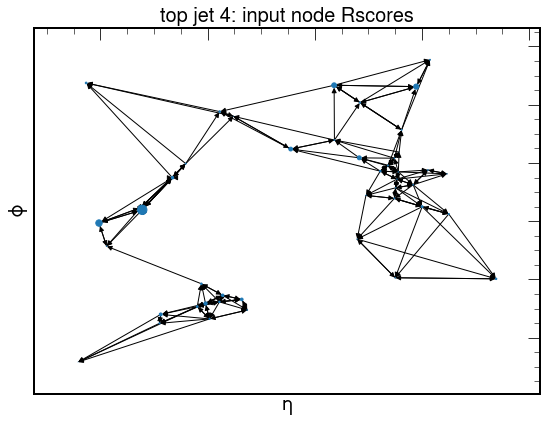

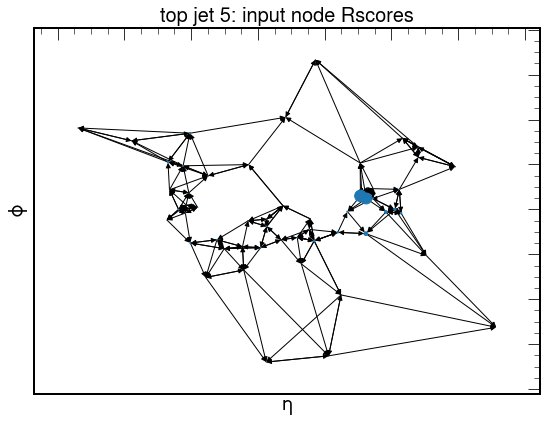

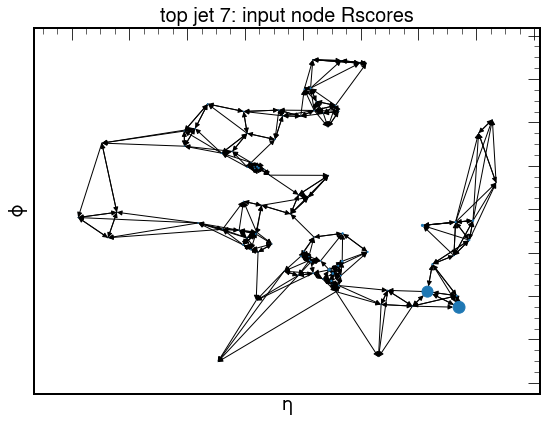

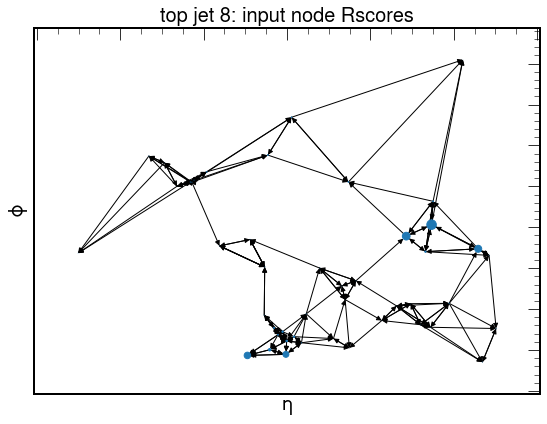

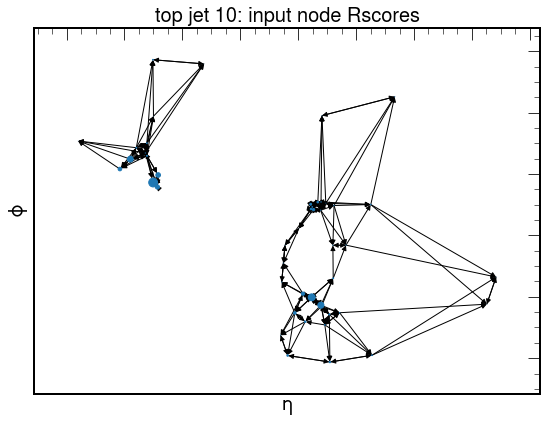

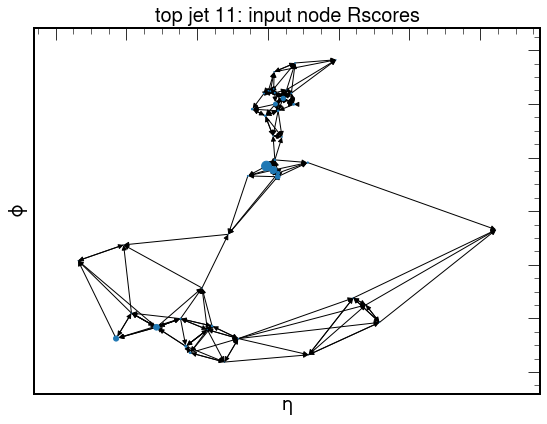

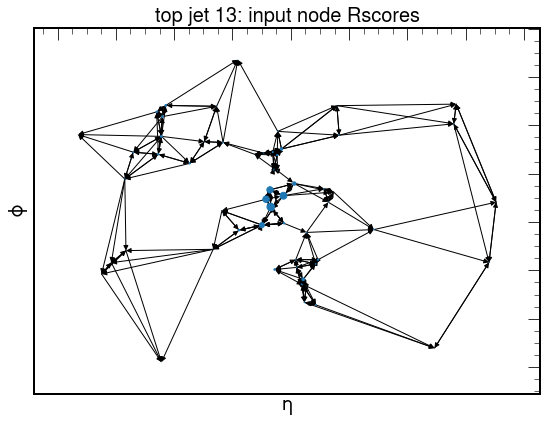

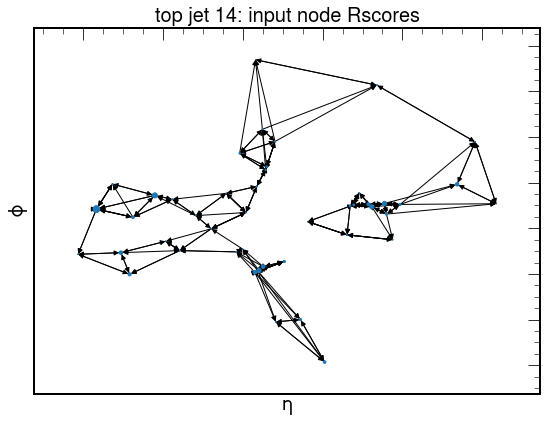

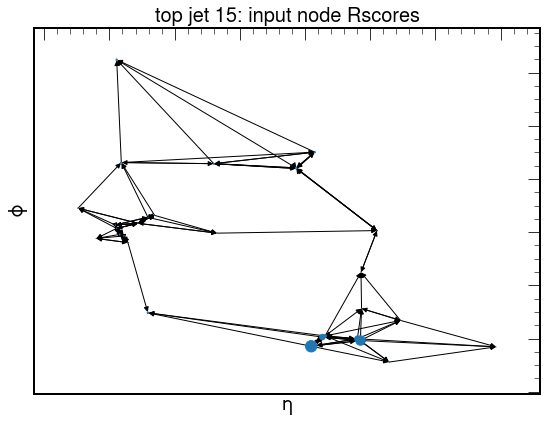

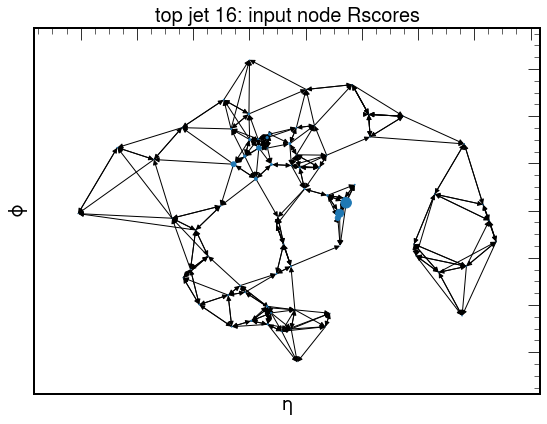

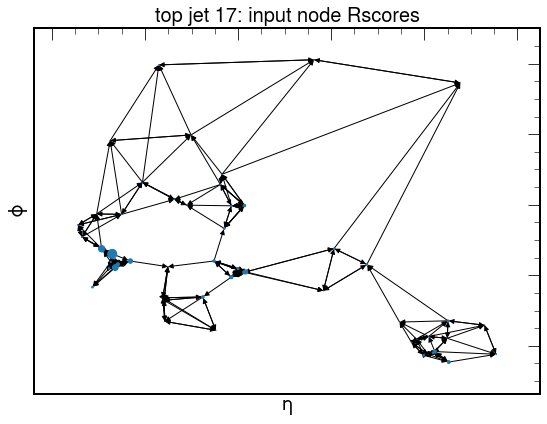

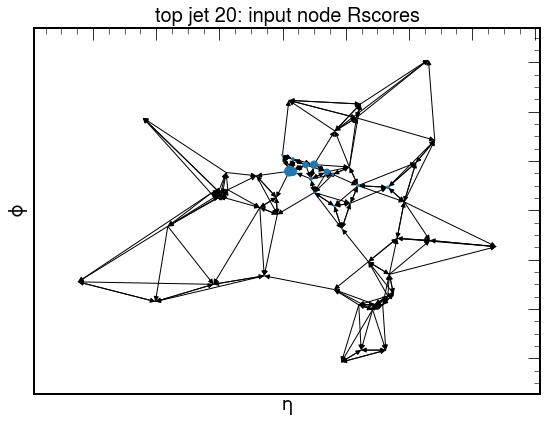

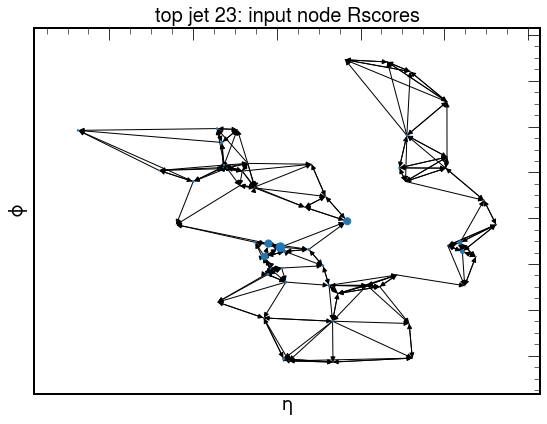

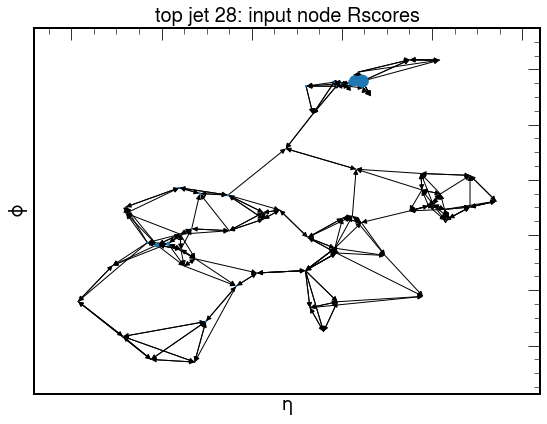

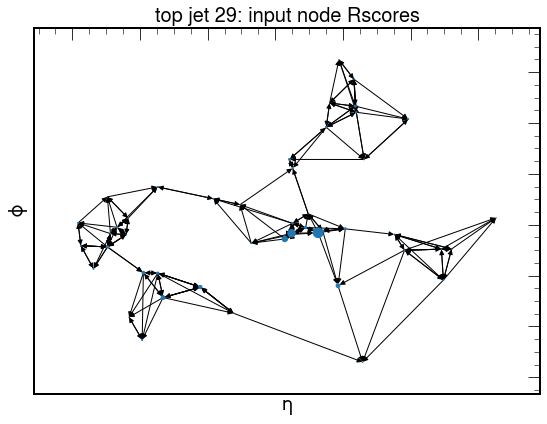

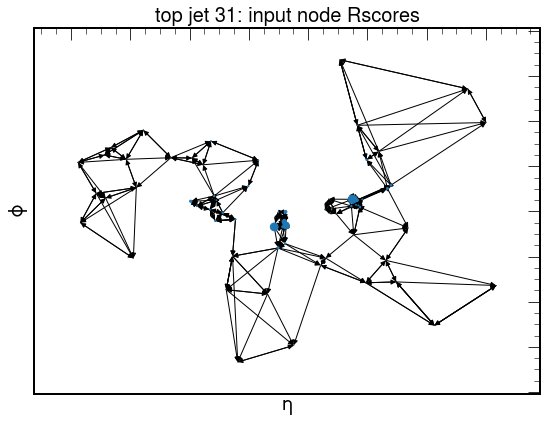

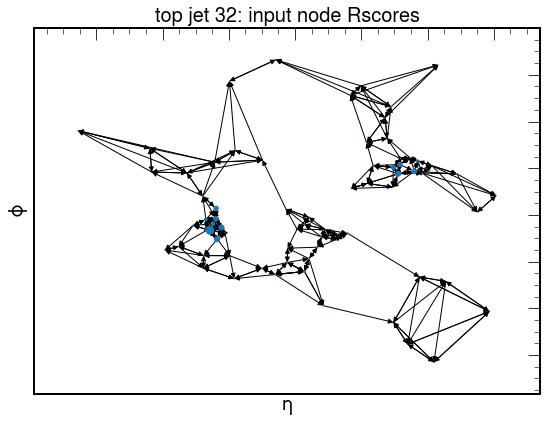

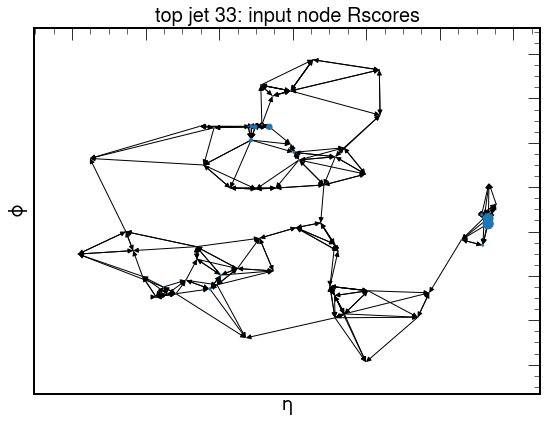

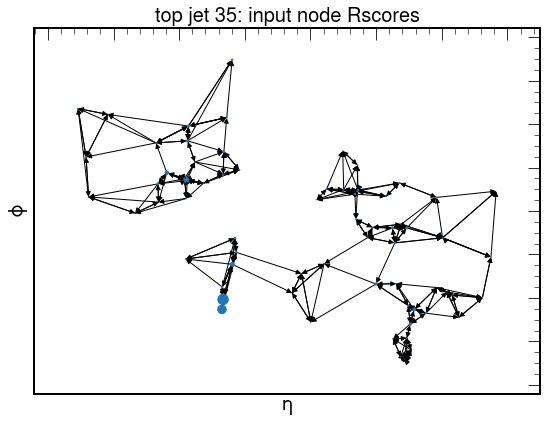

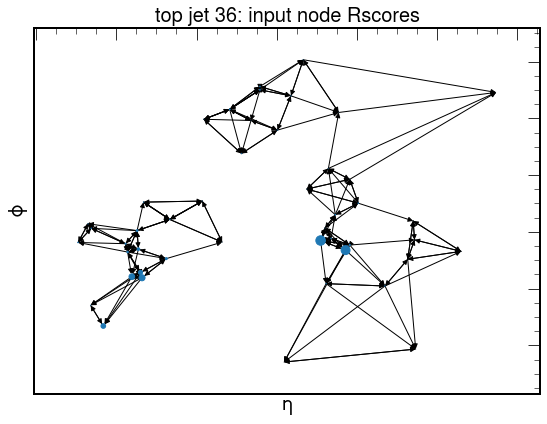

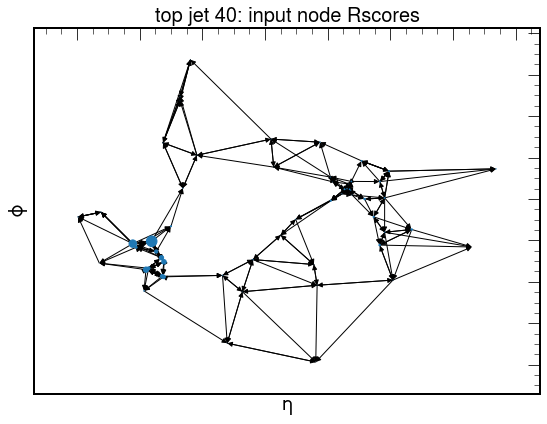

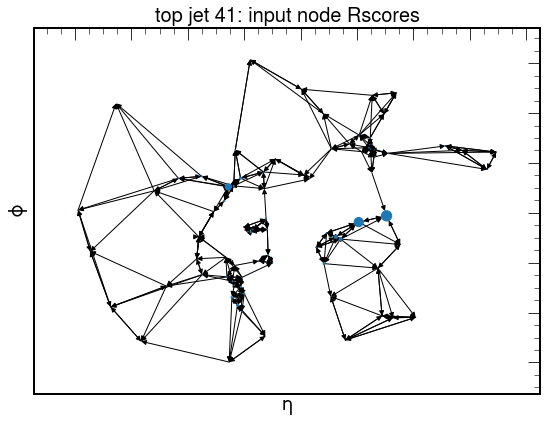

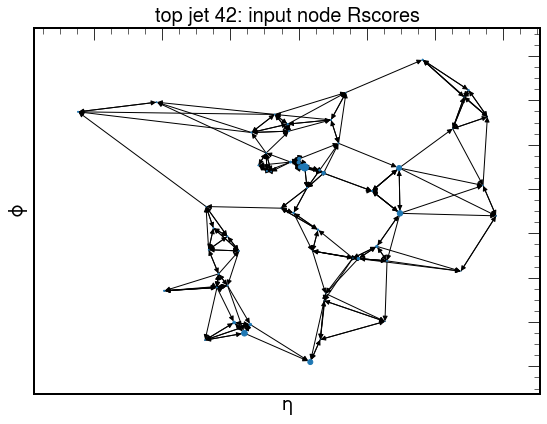

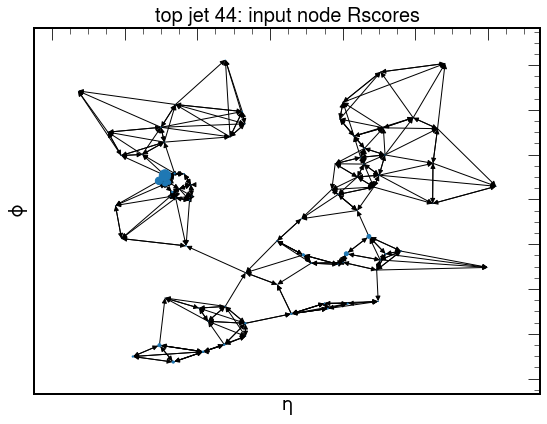

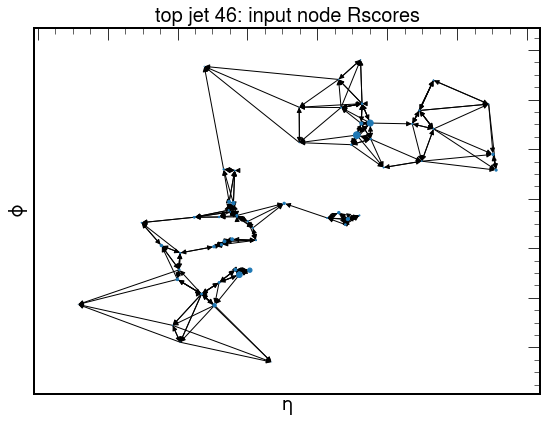

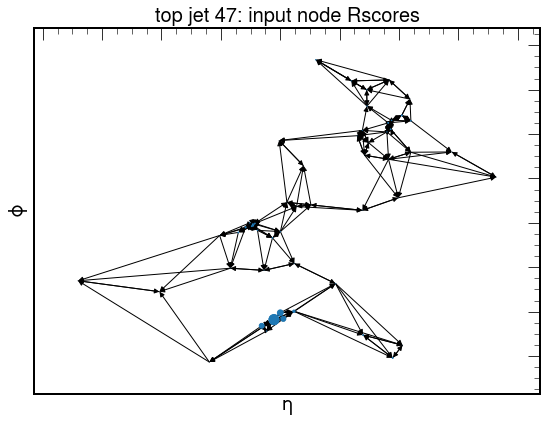

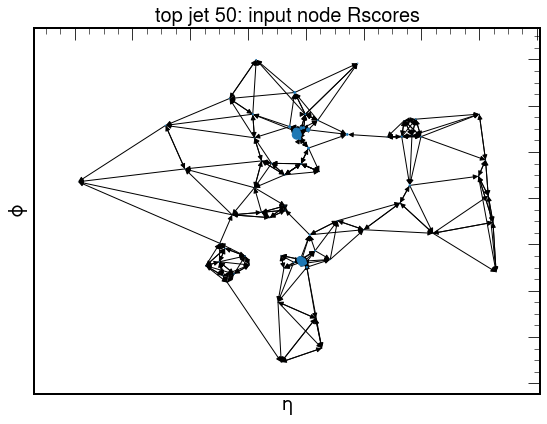

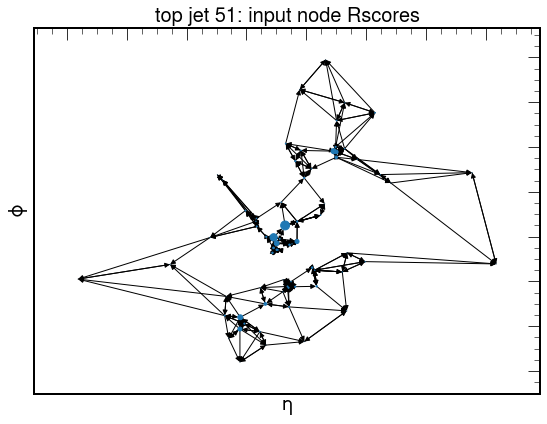

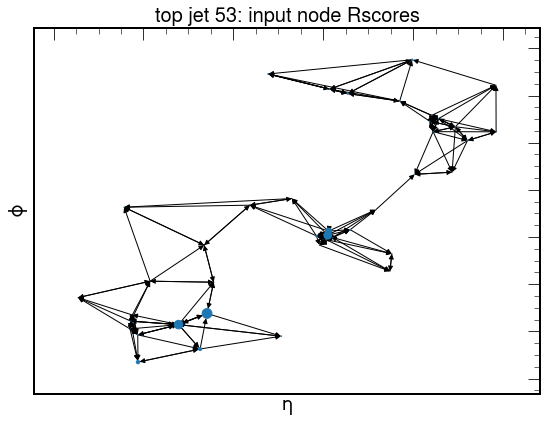

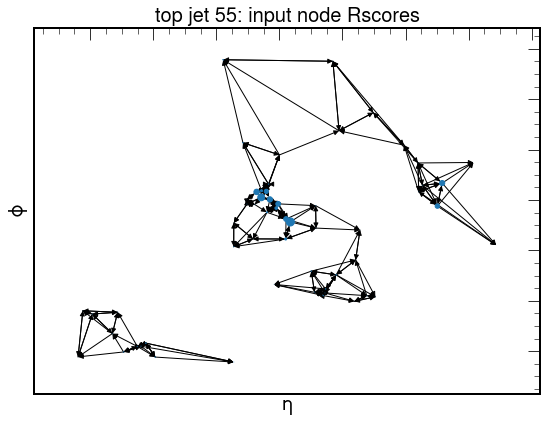

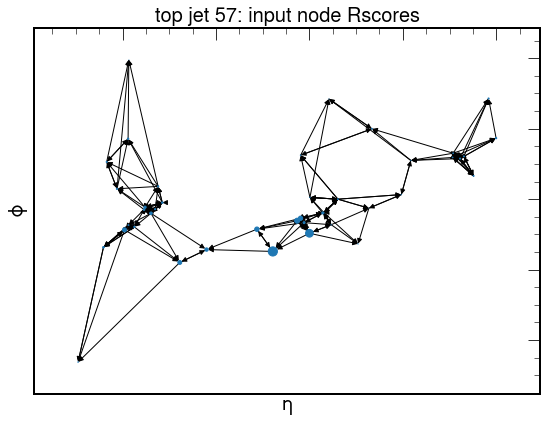

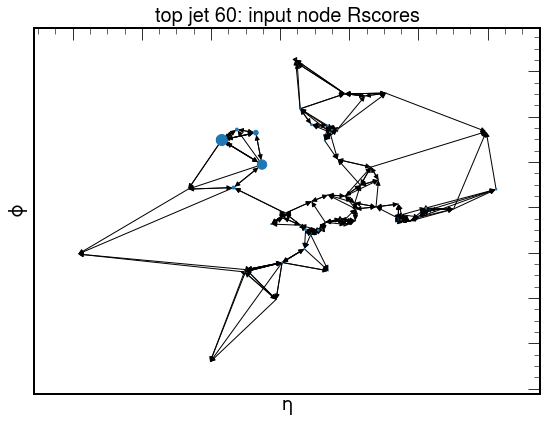

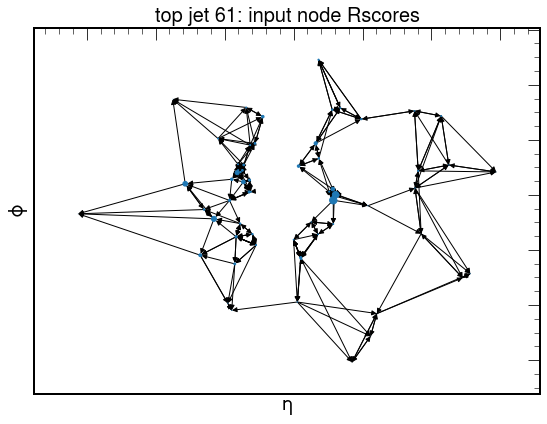

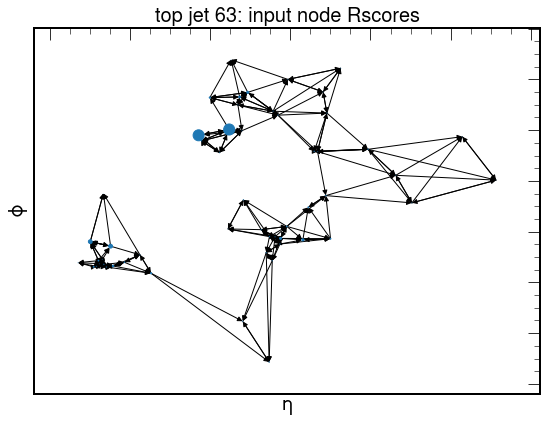

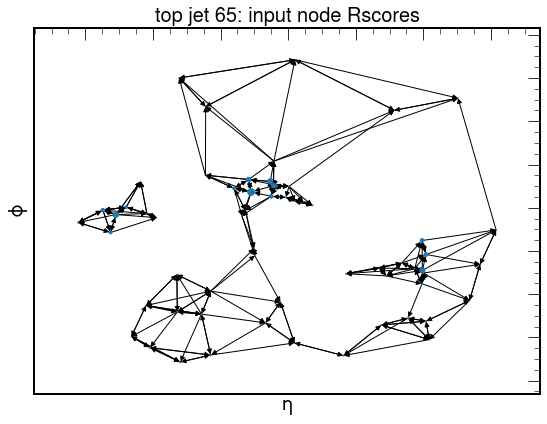

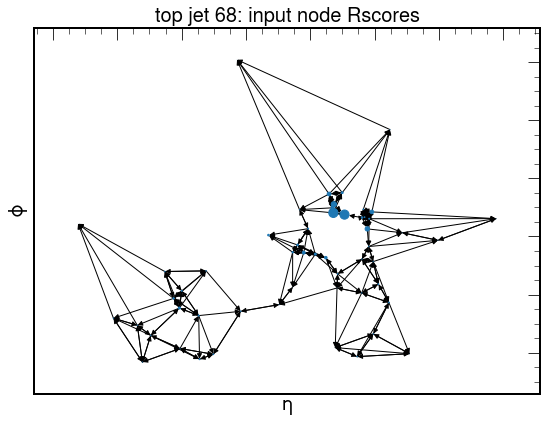

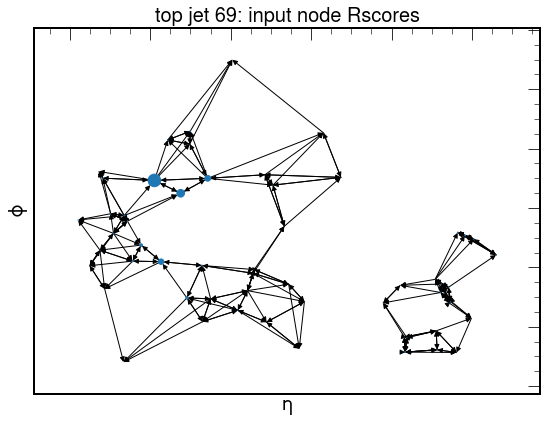

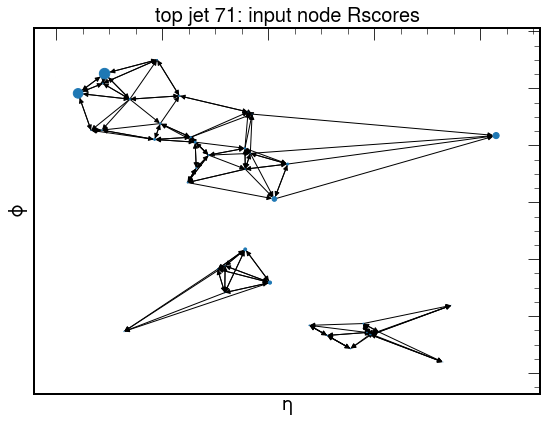

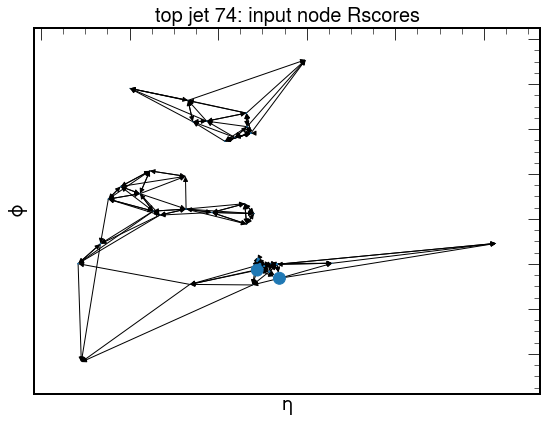

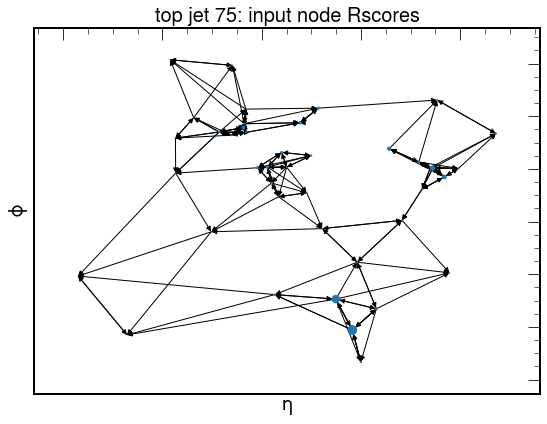

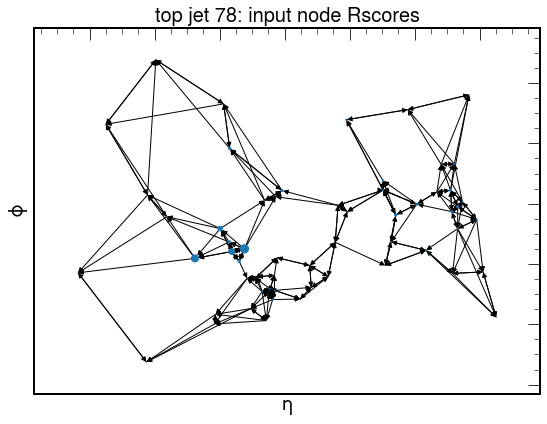

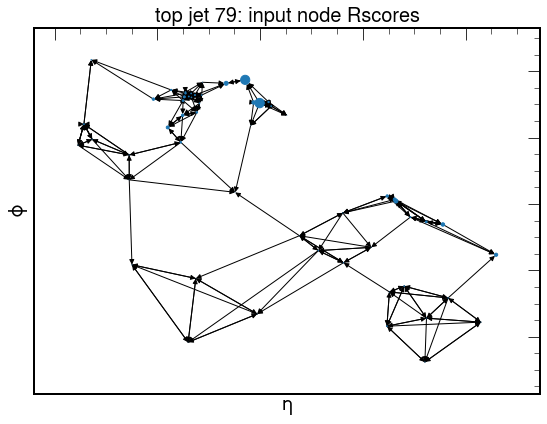

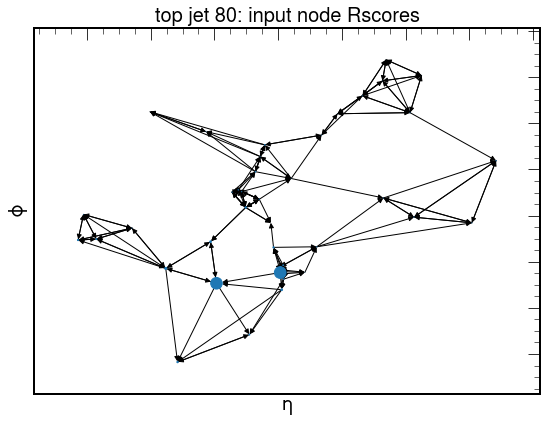

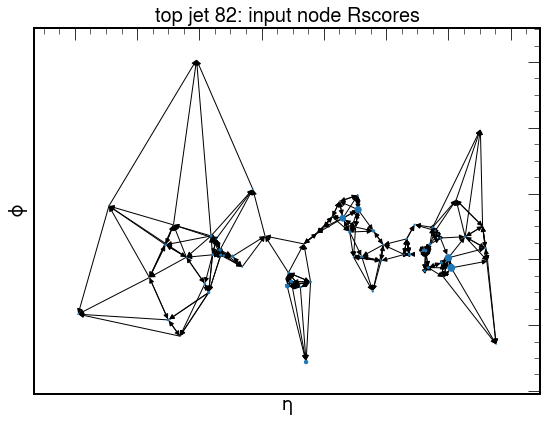

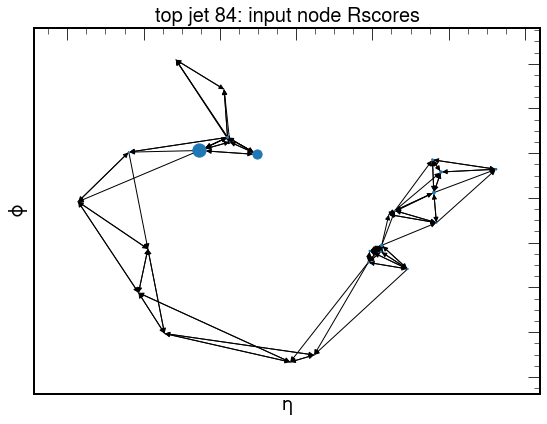

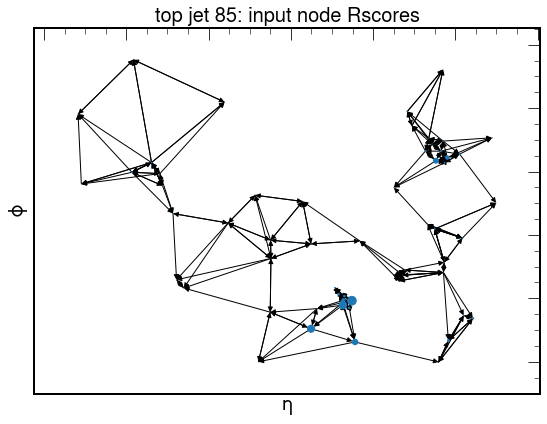

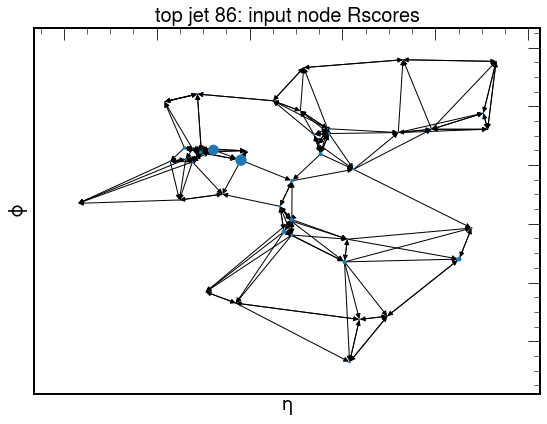

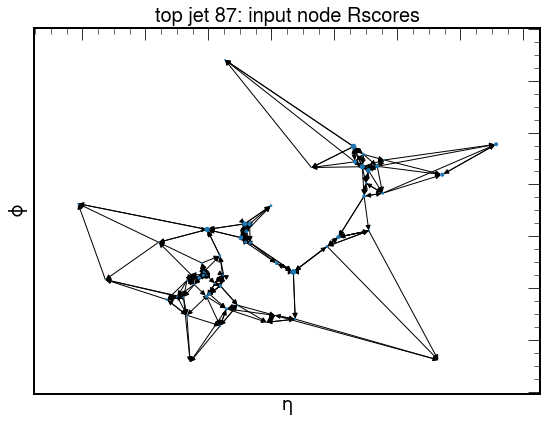

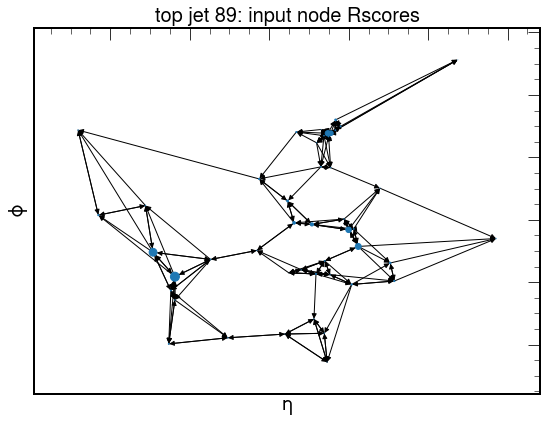

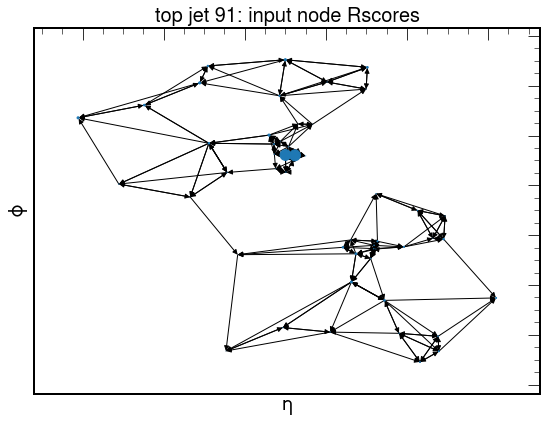

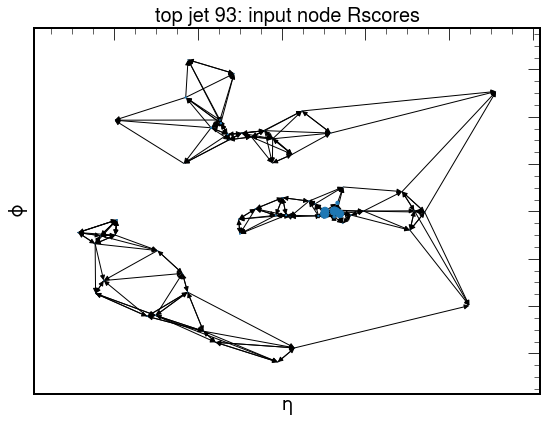

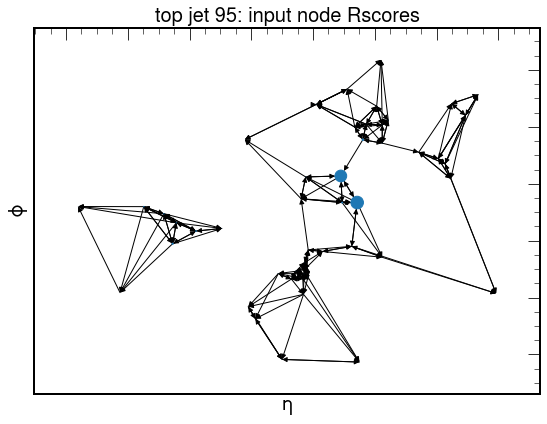

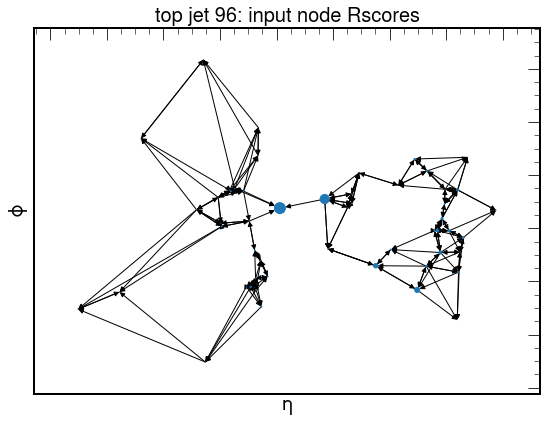

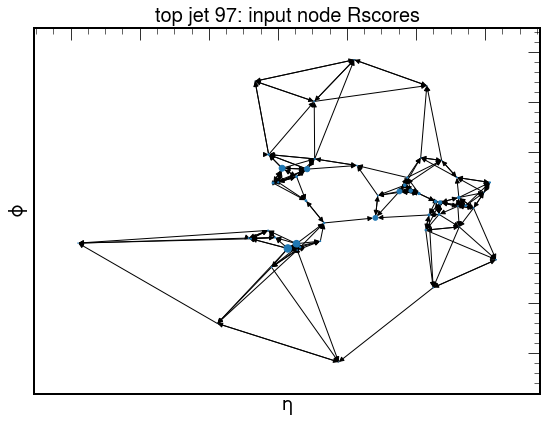

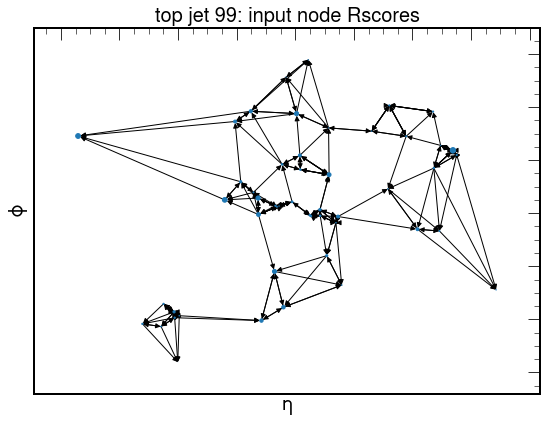

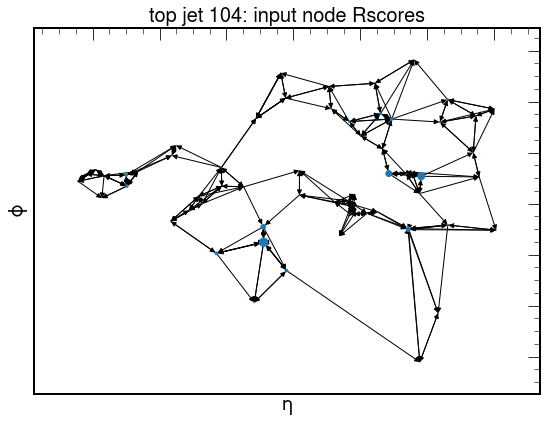

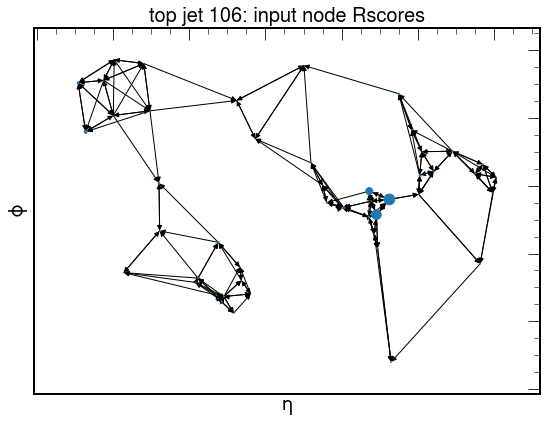

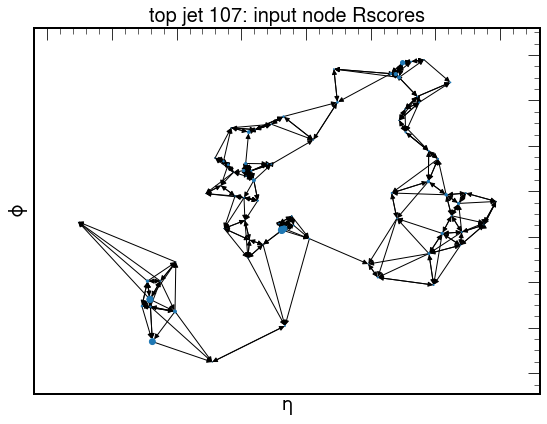

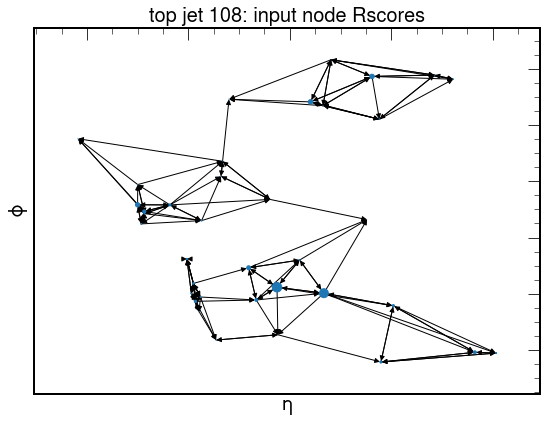

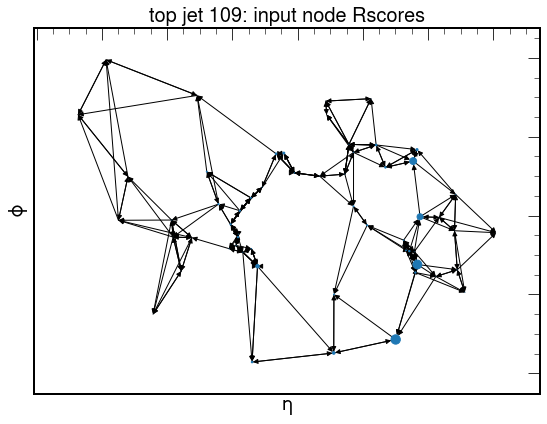

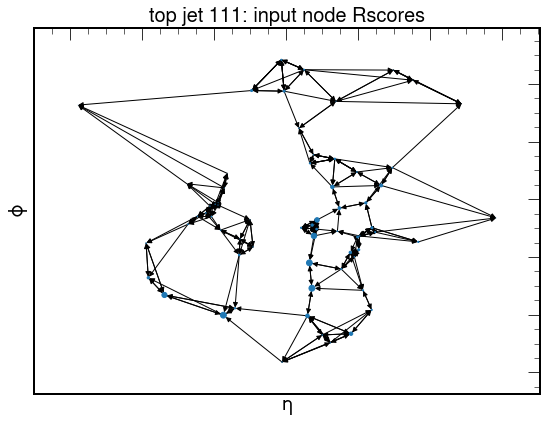

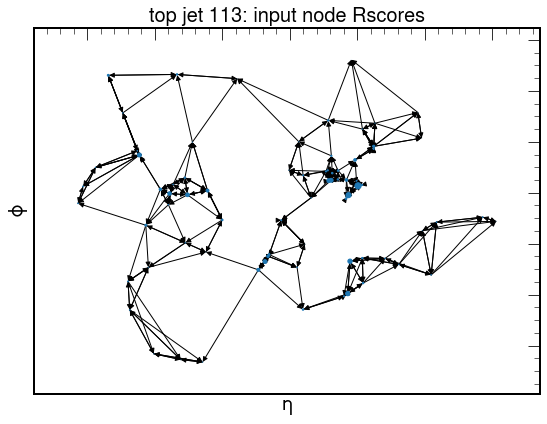

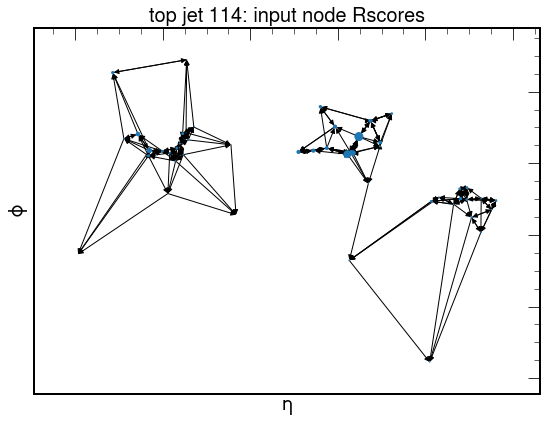

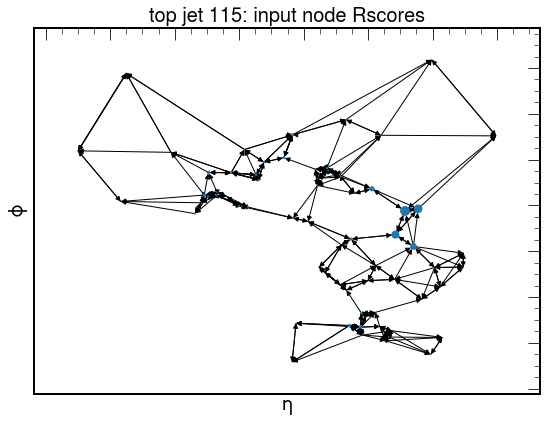

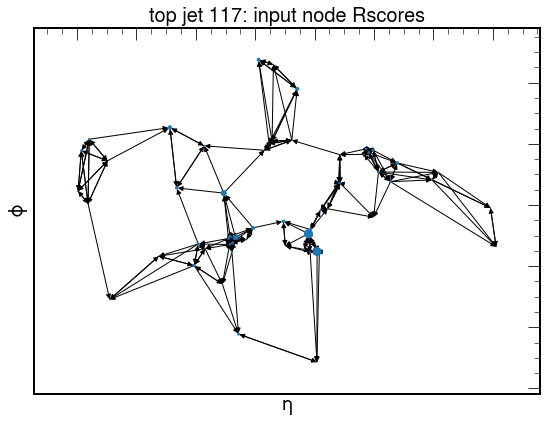

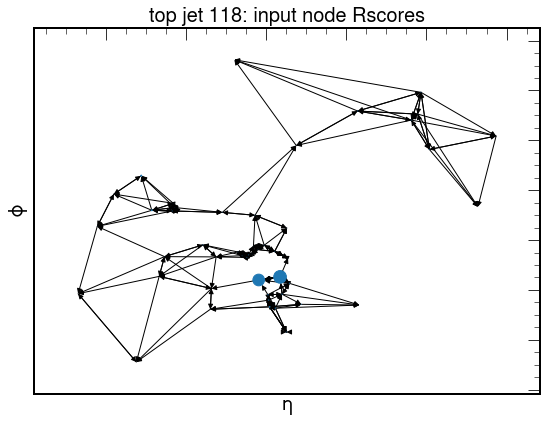

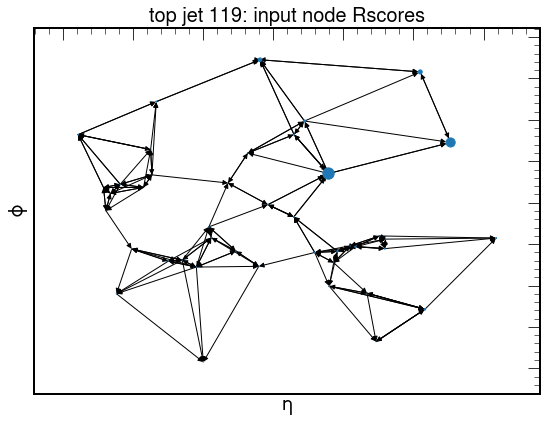

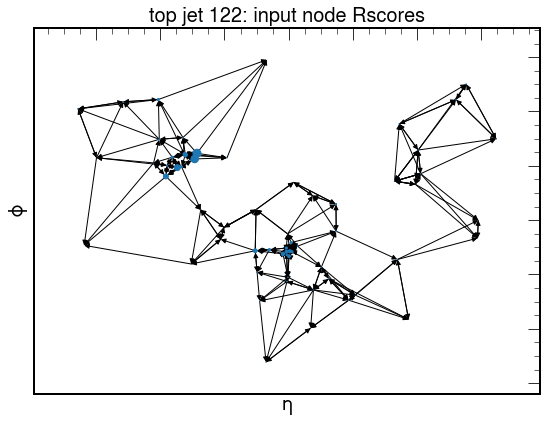

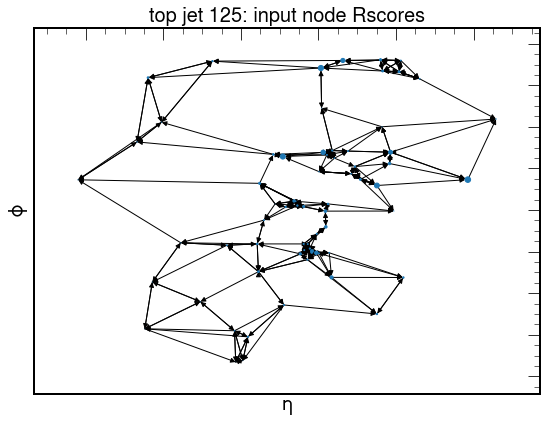

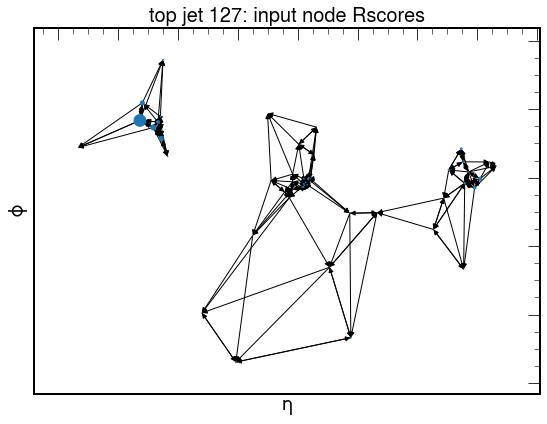

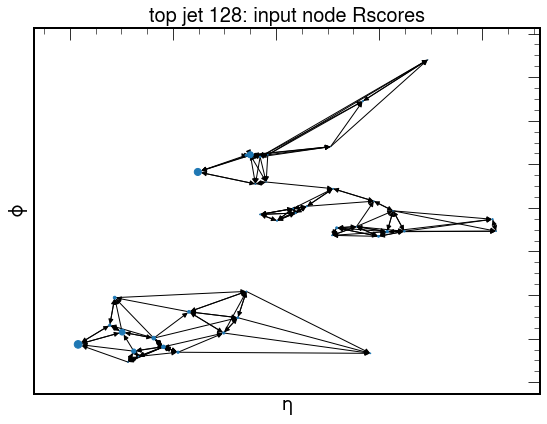

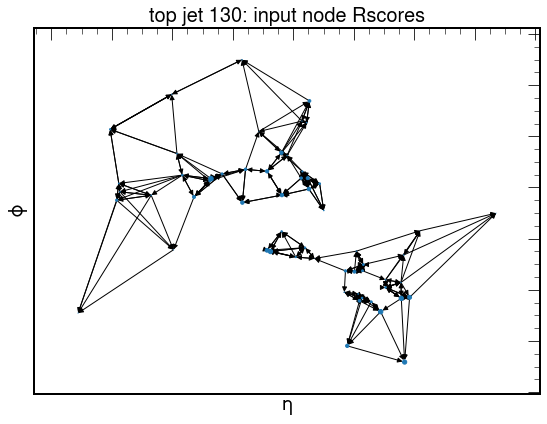

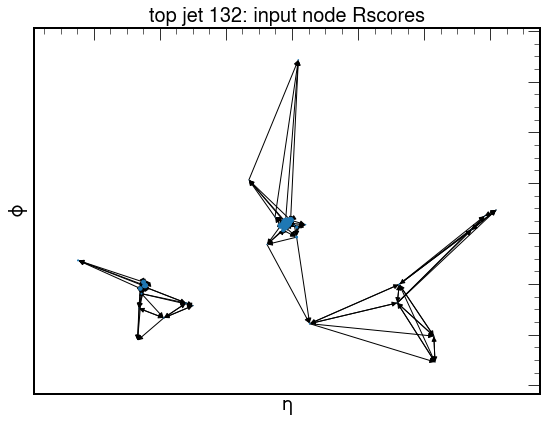

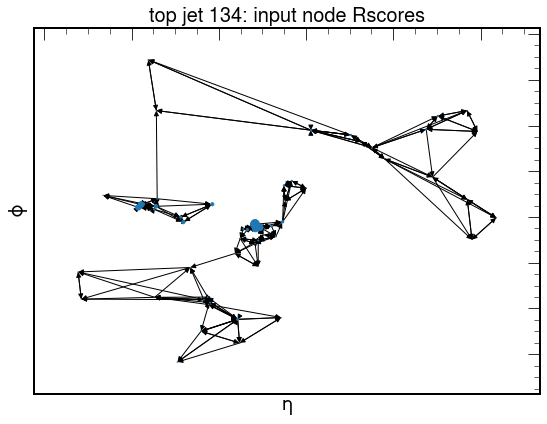

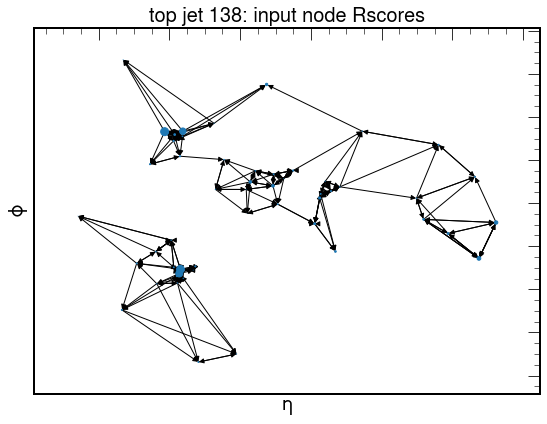

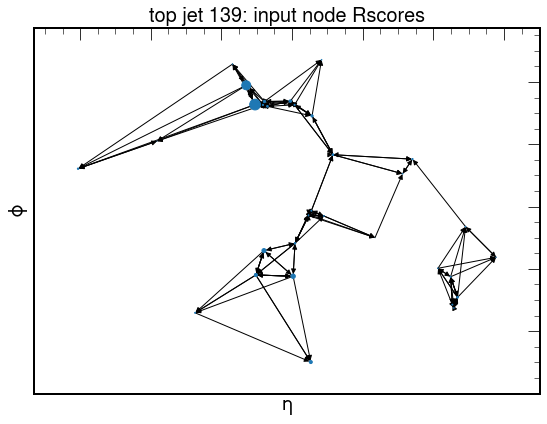

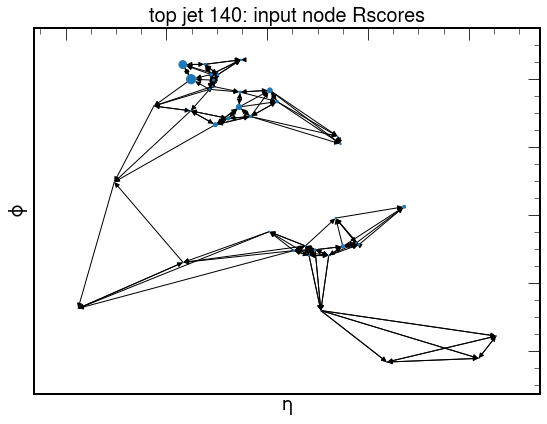

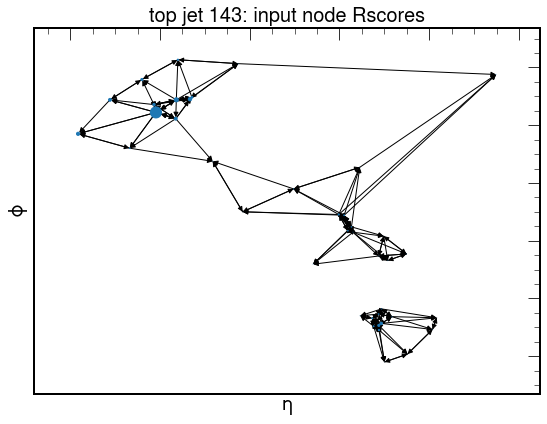

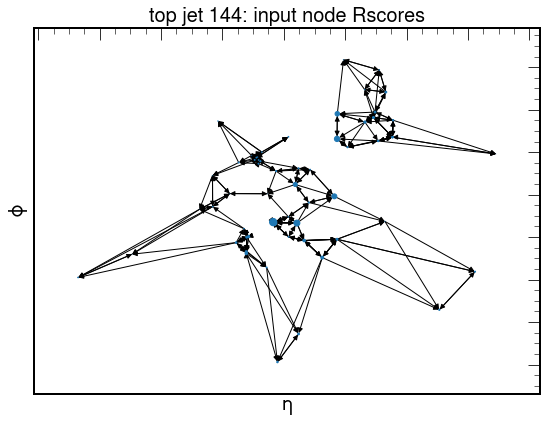

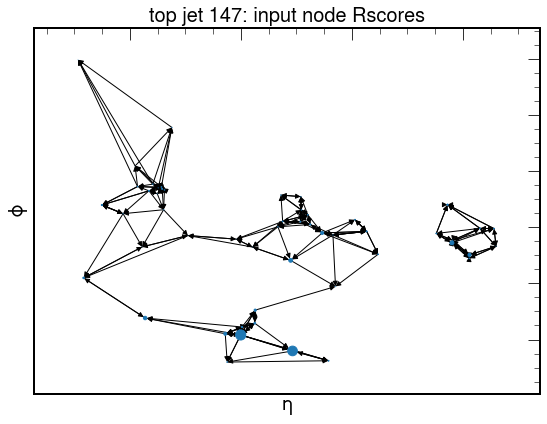

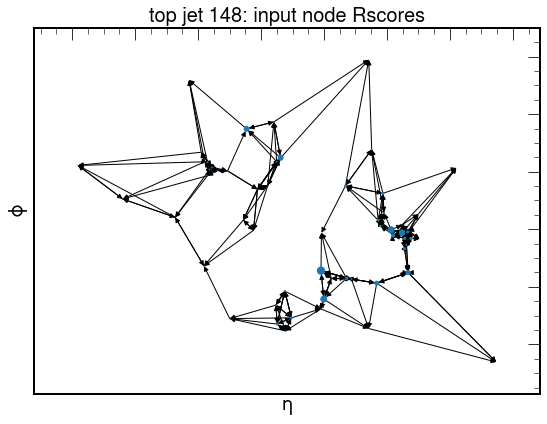

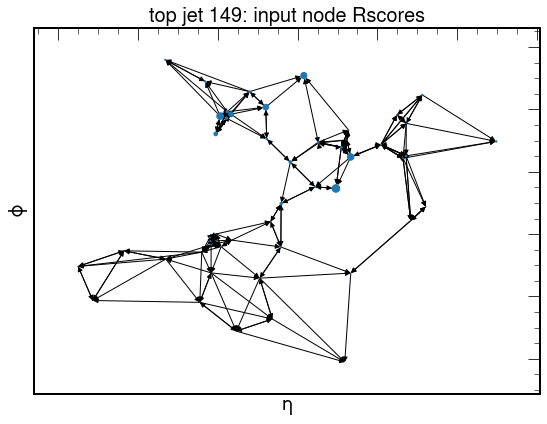

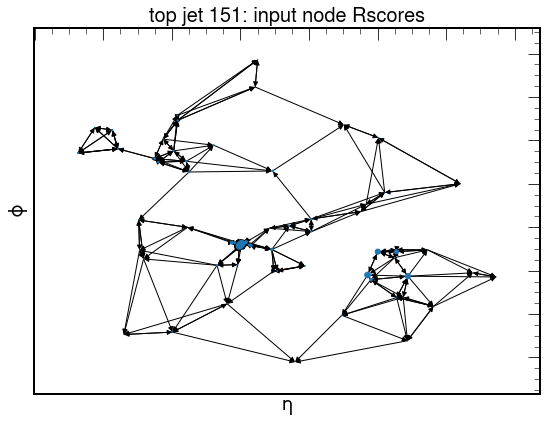

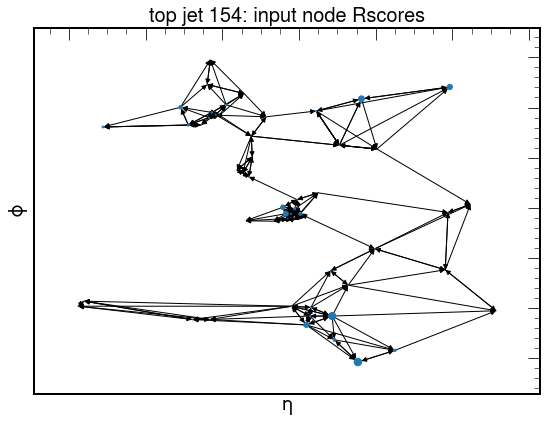

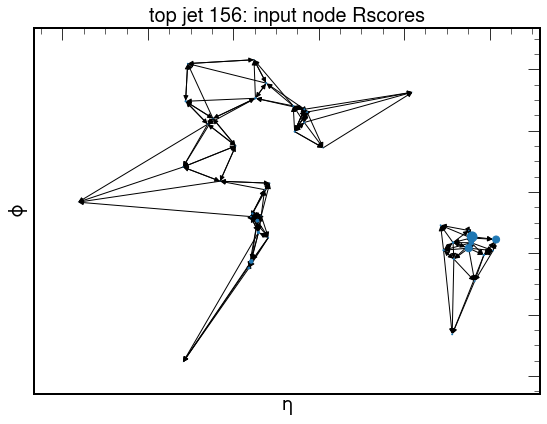

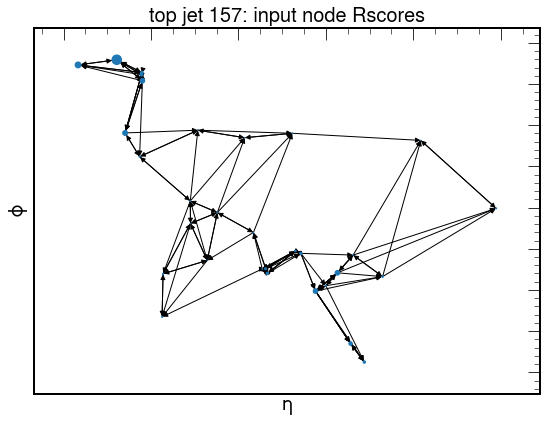

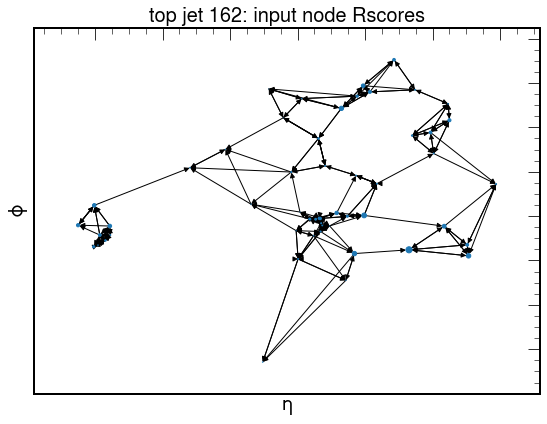

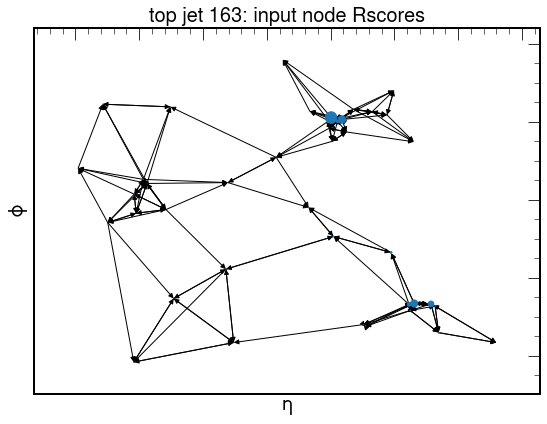

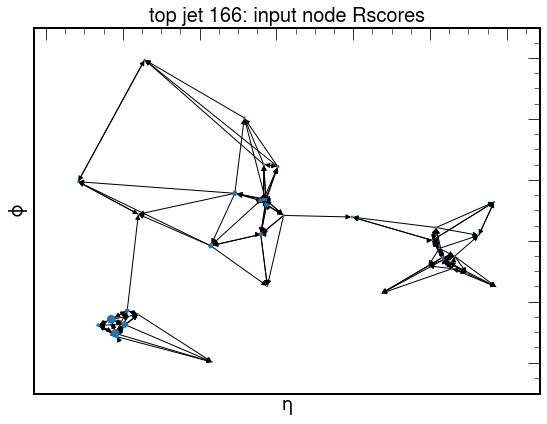

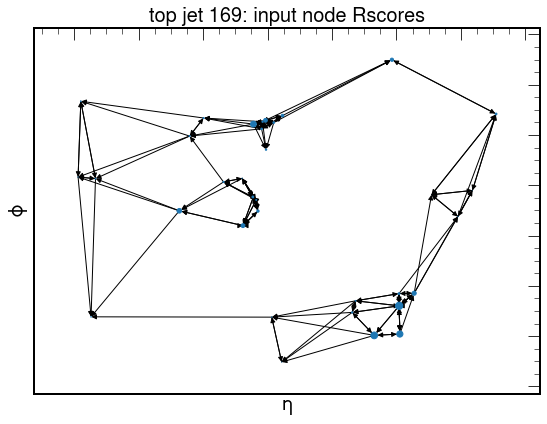

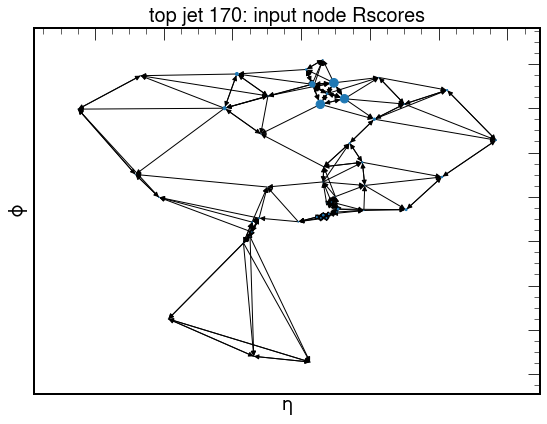

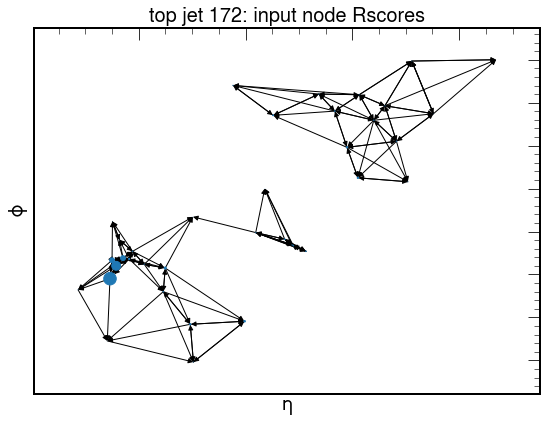

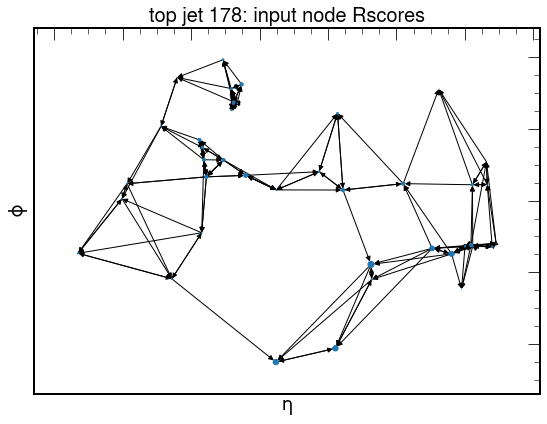

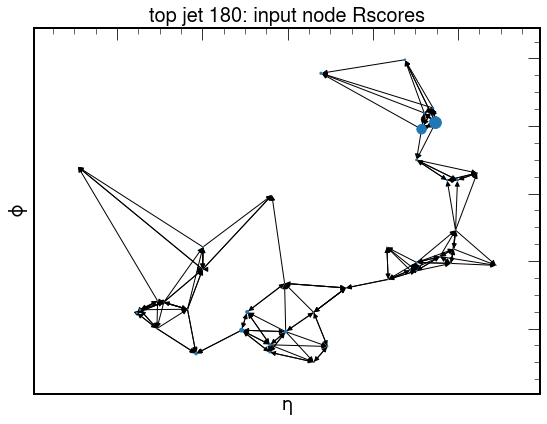

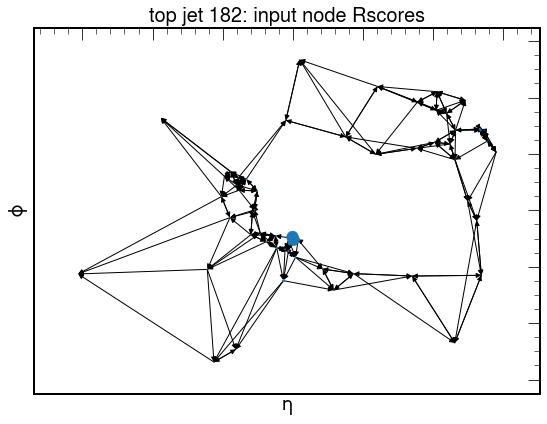

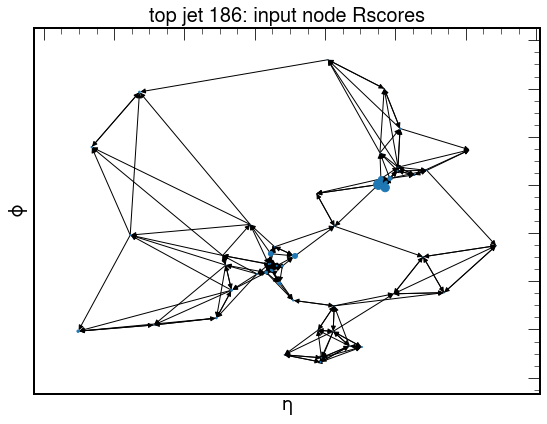

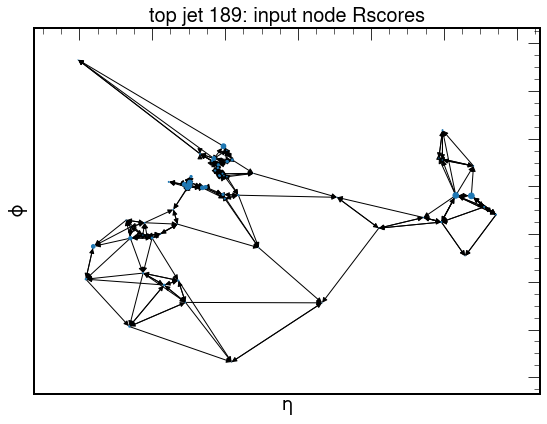

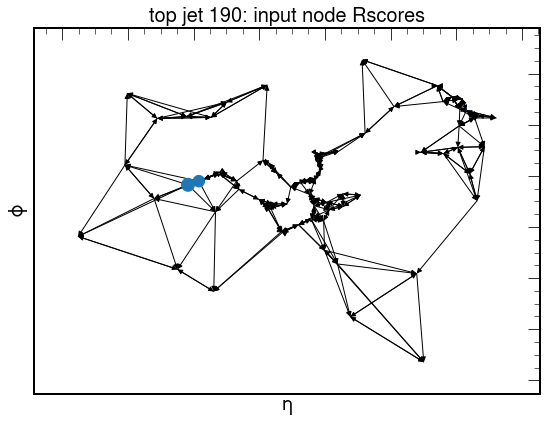

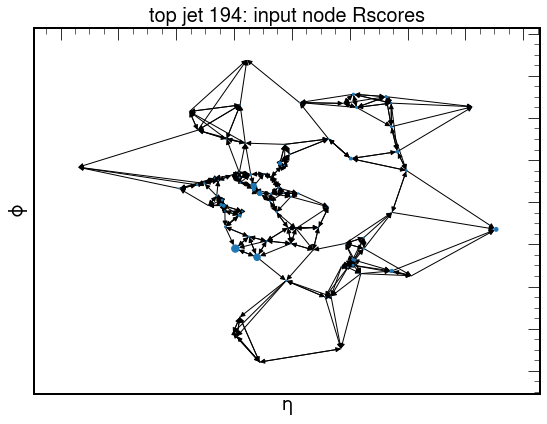

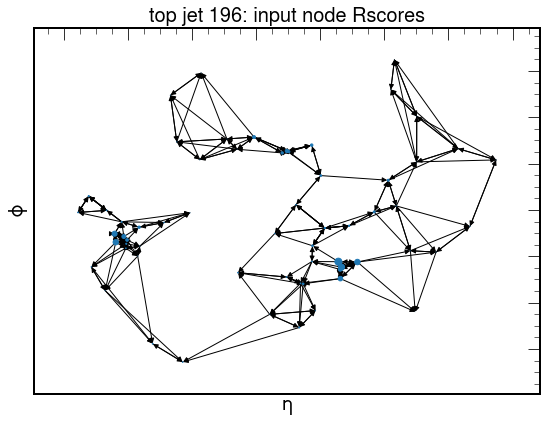

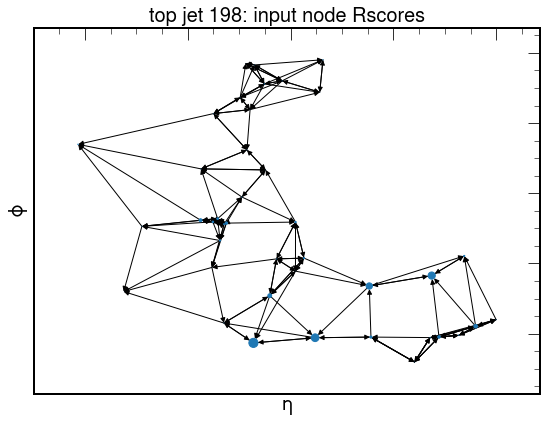

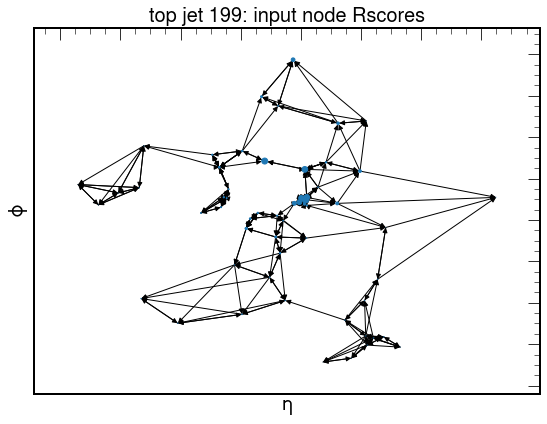

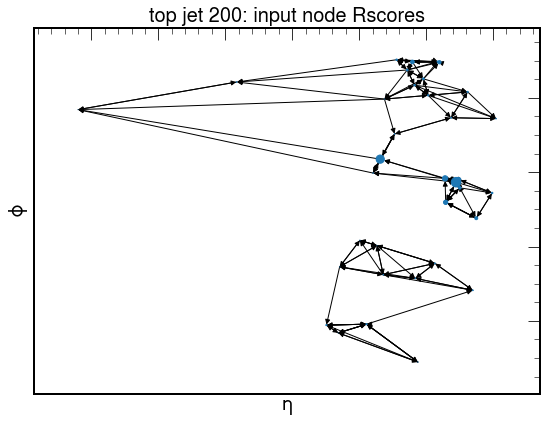

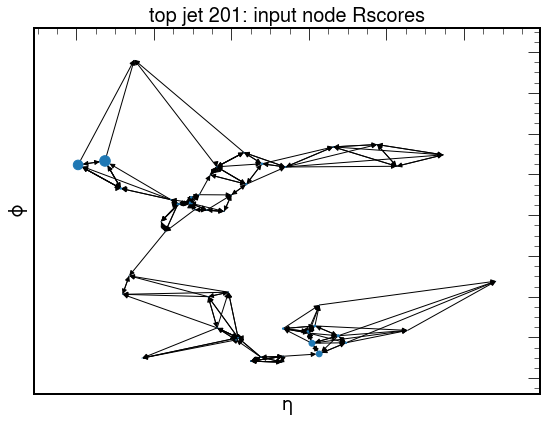

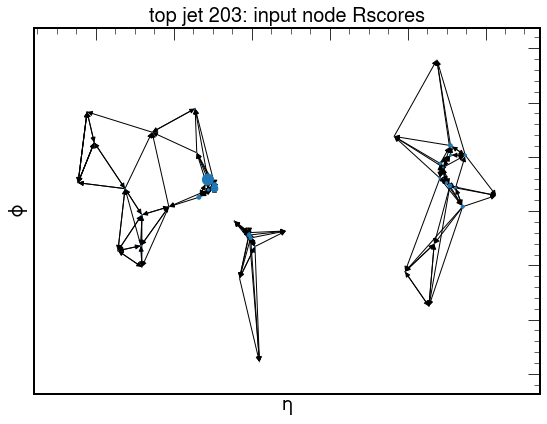

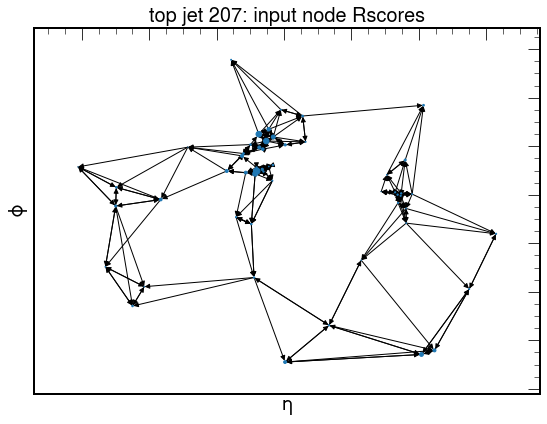

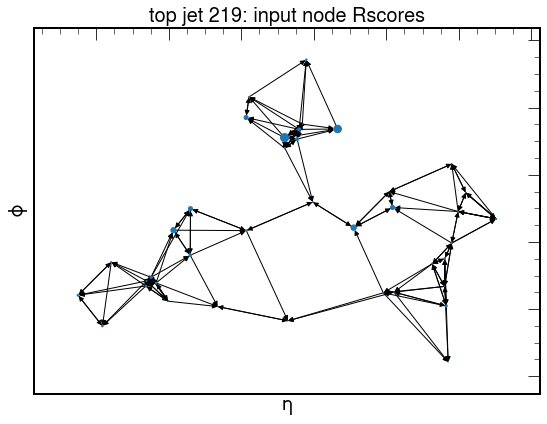

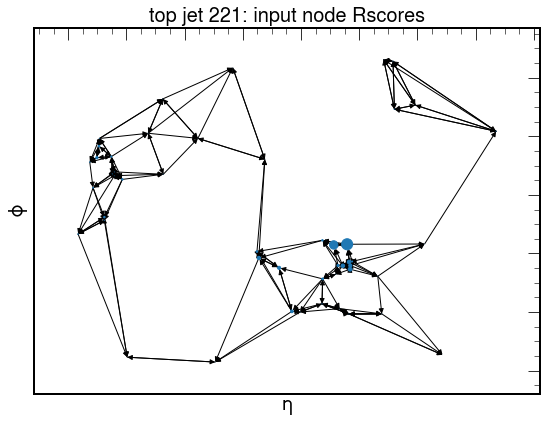

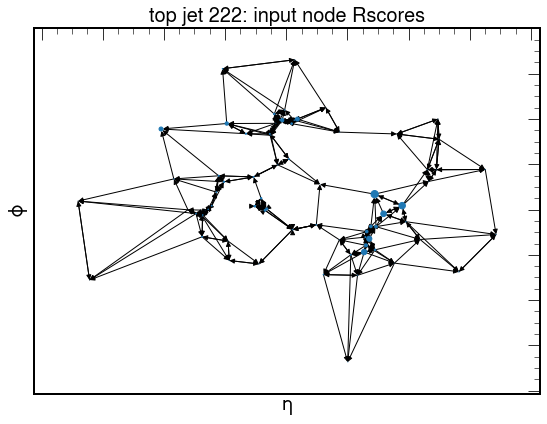

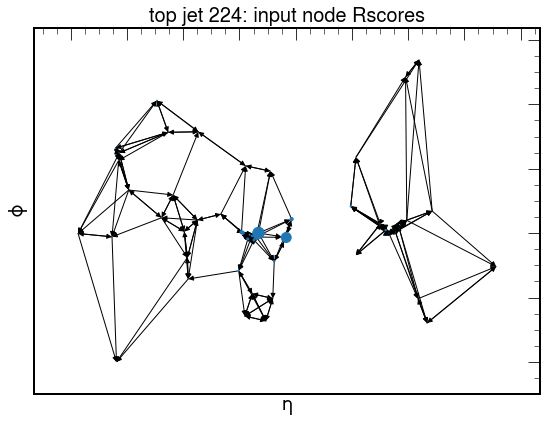

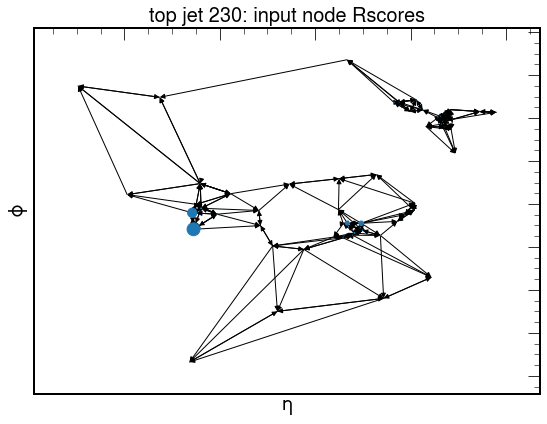

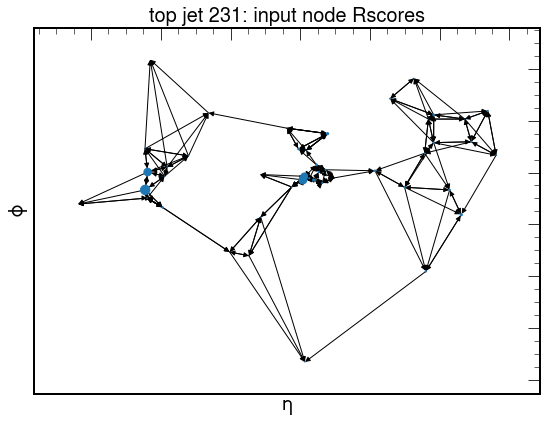

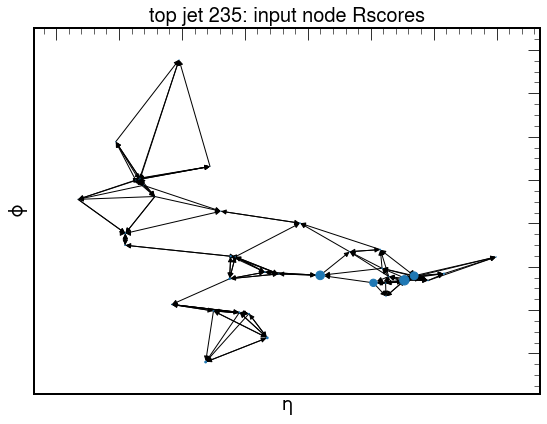

KeyboardInterrupt: 

In [104]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

sorted_Rscores_all = None

eta = []
phi = []
pt = []

### Input features Rscores
score = 0 # qcd
score = 1 # top

c = 0
for i in range(200):
#     if i!=6:
#         continue
    batch_y = batch_y_list[i]
    if batch_y==score:
        batch_x = batch_x_list[i]
        Rscores = Rscores_list[i]
        R_edges = R_edges_list[i]
        edge_index_dic = edge_index_list[i]

        if batch_y==1:
            sample = 'top'
        else:
            sample = 'qcd'
            
        model_score = round(sig(model(Batch(x=batch_x, y=batch_y, batch=torch.zeros(len(batch_x), dtype=int)))[0]).item(),3)            
            
        num_nodes = len(Rscores)
        
        node_Rscores = torch.abs(Rscores).sum(axis=1)   # sum features Rscores per node
        input_Rscores = node_Rscores/sum(node_Rscores)  # normalize sum of Rscores of all nodes to be 1  
        
#         c += 1        
#         if sorted_Rscores_all==None:
#             sorted_Rscores_all = torch.sort(input_Rscores, descending=True)[0][:5]  # top 5
#         else:
#             sorted_Rscores_all += torch.sort(input_Rscores, descending=True)[0][:5]  # top 5
        
#         _, ind = torch.sort(input_Rscores, descending=True)  # top 5
        
#         eta.append(batch_x[ind[0]][0])
#         phi.append(batch_x[ind[0]][1])
#         pt.append(batch_x[ind[0]][2])
        
        # Get positions of nodes in the graph
        # recall: Features, in order: [eta, phi, pt, mask].
        eta = batch_x[:, 0]
        phi = batch_x[:, 1]
        pt = np.abs(batch_x[:, 2])

        eta_phi = batch_x[:, :2]
        
        pos = {}
        for node_i in range(num_nodes):
            pos[node_i] = eta_phi.numpy()[node_i]

        # build graph
        to_undirected = False
        
        # if directed
        if to_undirected == False:
            edge_index = edge_index_dic['edge_conv_0']

        # if undirected
        else:
            edge_index = torch_geometric.utils.to_undirected(edge_index_dic['edge_conv_0'])

        data = torch_geometric.data.Data(edge_index=edge_index, num_nodes=num_nodes)
        G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

        fig, ax = plt.subplots(figsize=(8, 6))
        nx.draw_networkx(G, pos, node_size=300*input_Rscores, with_labels=False, ax=ax)   

        ax.set_xlabel(r"$\eta$", fontsize=20)
        ax.set_ylabel(r"$\phi$", fontsize=20);
        fig.tight_layout()
        ax.set_title(f'{sample} jet {i}: input node Rscores', fontsize=20);
#         plt.savefig(f'xai_plots/input/InputRgraph_{i}.pdf')
        plt.show()

In [280]:
eta_top = eta
phi_top = phi
pt_top = pt

In [282]:
eta_qcd = eta
phi_qcd = phi
pt_qcd = pt

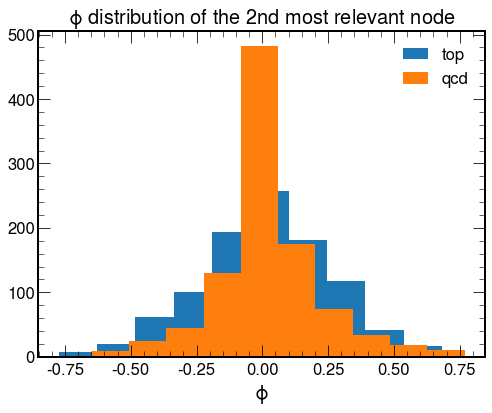

In [272]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(phi_top, label='top')
ax.hist(phi_qcd, label='qcd')

ax.set_xlabel(r"$\phi$", fontsize=20)
ax.set_title(f'$\phi$ distribution of the 2nd most relevant node', fontsize=20);
ax.legend()
plt.show()

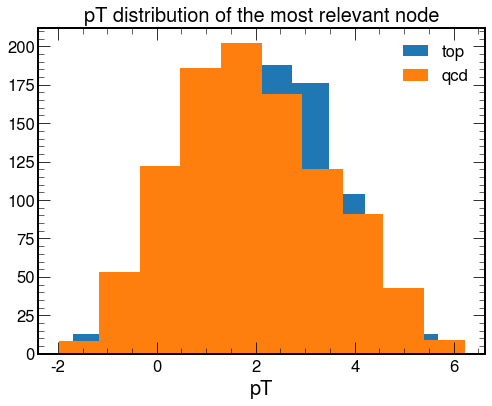

In [283]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(pt_top, label='top')
ax.hist(pt_qcd, label='qcd')

ax.set_xlabel(r"pT", fontsize=20)
ax.set_title(f'pT distribution of the most relevant node', fontsize=20);
ax.legend()
plt.show()

In [233]:
sorted_Rscores_all_top = sorted_Rscores_all
c_top = c

In [231]:
sorted_Rscores_all_qcd = sorted_Rscores_all
c_qcd = c

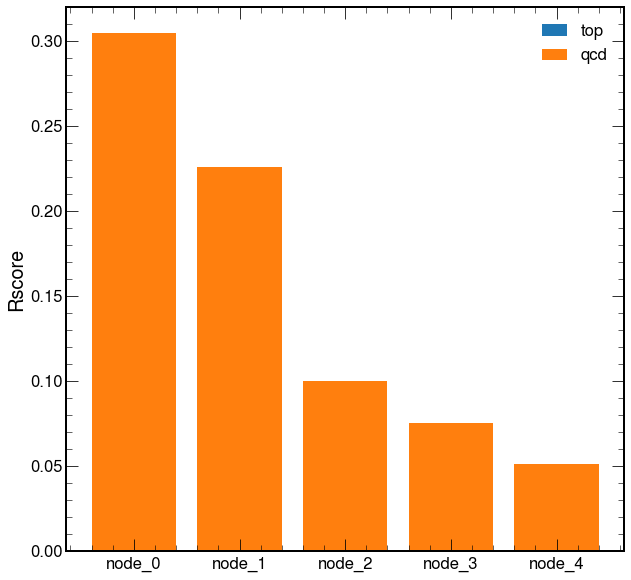

In [244]:
plt.bar(range(0,5), sorted_Rscores_all_top/c_top, width=0.8, bottom=None, align='center', label='top')
plt.bar(range(0,5), sorted_Rscores_all_qcd/c_qcd, width=0.8, bottom=None, align='center', label='qcd', tick_label=[f'node_{i}' for i in range(5)])
plt.ylabel('Rscore')
plt.legend()

In [245]:
sorted_Rscores_all_qcd/c_qcd

tensor([0.3047, 0.2256, 0.1002, 0.0750, 0.0513])

In [246]:
sorted_Rscores_all_top/c_top

tensor([0.3013, 0.2245, 0.0966, 0.0728, 0.0493])

In [128]:
c = 0

for i in range(200):
    batch_y = batch_y_list[i]
    if batch_y==score:
        batch_x = batch_x_list[i]
        Rscores = Rscores_list[i]
        R_edges = R_edges_list[i]
        edge_index_dic = edge_index_list[i]
    
    jet = Batch(x=batch_x, y=batch_y, batch=torch.zeros(len(batch_x), dtype=int))
    out, _, _, _ = model(jet)
    model_score = round(sig(out).item(),3)            
    
    if round(model_score)==batch_y:
        c = c+1


In [136]:
threshold = 0.5
c = 0
for i, batch in enumerate(loader):
    preds, _, _, _ = model(batch)
    preds = sig(preds).detach()
    
    model_score = preds.item()
    model_score = math.ceil(model_score-threshold)
    if round(model_score)==batch.y:
        c = c+1
    if i==1000:
        break

In [137]:
c/1000

0.849